In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'../..')

In [4]:
import os

os.getcwd()

'/Users/spindicate/Documents/programming/investing/analysis/options/phat/docs/notebooks'

In [3]:
from datetime import datetime as dt
import warnings

import numpy as np
import scipy.stats as scist
import pandas as pd
import scipy.stats as scist
import matplotlib.pyplot as plt
import matplotlib.ticker as mticks

import seaborn as sns; sns.set(style = 'whitegrid')
import yfinance as yf

from phat import CarbenHybrid, Phat
from phat.dists import BLineSig, LogPareto, DBLGP

# Simulating Share Price Movements w Fat Tails #

## What Are Fat Tails? ##

### Thin v. Fat ###

SCOFT pg. 89

+ Probabliity distributions range from very thin-tailed to very fat-tailed
+ Taleb formally defines fat-tailed distributions as ones where the tail events dominate the distributions characteristics (moments etc.) and their impacts. Others refer to this root class as heavy tails, reserving "fat" tails for the most dramatic subset.
+ Taleb suggests "subexponential" distributions as the borderline between thin and fat tails, which are defined in terms of the slope of their survival functions:
    + the slope of thin-tailed survivial functions such as the guassian decay exponentially towards $\infty$
    + the slope of heavy-tailed decay survival functions decay at a rate slower than exponential, at a minimum, with the more dramatic fat tails decaying linearily (or not decaying at all).
    + Subexponential distributions will have a kurtosis > 3 (kurtosis of Gaussian)

### The Borderline ###
+ Taleb defines the borderline distribution between thin and fat where the ratio of the power over the root is 1, for a two-tailed distribution where $F$ covers $(0,1)$ between $(-\infty, +\infty)$.

$$\lim\limits_{x\to+\infty}\frac{F(x)^n}{F(nx)} = 1$$

+ A sample of such a distribution is suggested as:

$$
F(x) = \frac{1}{2}(1 - tanh(kx)), \kappa > 0
\\ f(x) = \frac{1}{2}ksech^2(kx)
$$

The kurtosis of the above distribution is 4.2, which is greater than 3 (the kurtosis of the standard normal), and so it has slightly fatter tails.


This distribution is available in the package as BLineSig (name referencing the fact it is a sigmoid). In the figure below, we can the slightest difference in the head, shoulders, and tail versus the Gaussian.

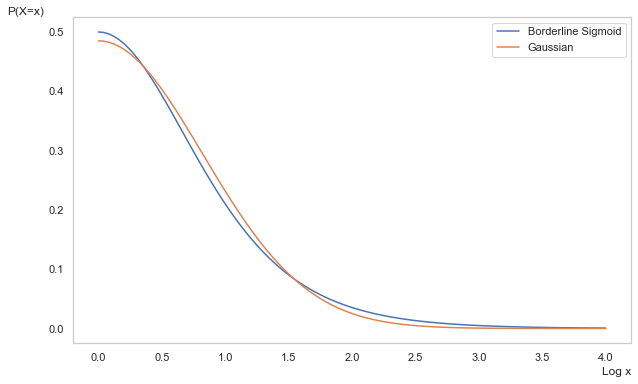

In [81]:
k = 1
x = np.linspace(0,4,100)
bline = BLineSig(k)
norm = scist.norm(scale=bline.var())

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(x, bline.pdf(x), label='Borderline Sigmoid')
ax.plot(x, norm.pdf(x) , label='Gaussian')

ax.set_ylabel('P(X=x)', loc='top', rotation='horizontal')
ax.set_xlabel('Log x', loc='right')

plt.legend()

ax.grid(False)
plt.show()

### Difference in the Tails ###

So a distribution need only have kurtosis > 3 to be classified a fat tail (at least, by Taleb). But we can further distinguish between fat tails based on their differing behavior in the tails, namely the change in slope of the tail as $n\to\infty$. This slope is referred to as the "tail index", designated $\alpha$ by Taleb (and many other greeks by many others).

Thin tails such as the Gaussian have non-linear tails whose slopes decay towards infinity, i.e. $\alpha\to\infty$ as $n\to\infty$, meaning the distributions reach an effective maximum. At this level, E(X | X > x) = X, meaning there are no values $> x$ expected in the distribution.

The more dramatic fat tails tend to a non-zero, non-infinite slope, meaning they have no effective maximum. These include the Power Laws. The Power Laws also result in other strange characteristics (relative to normal statistics) such as undefined moments including undefined variance ($\alpha < 2$) *and* undefined mean ($\alpha < 1$).

Below we show both linear and log-log scales of the Guassian thin tail versus 3 subexponential distributions: 

+ our Borderline distribution, which is barely fat tail
+ the Lognormal (shape=2), which is a fat tail masquerading as a power law, that is revealed as an imposter at larger x.
+ the Student's T (df=3), which is oftened defined as a power law, though it only tends to one at larger x.

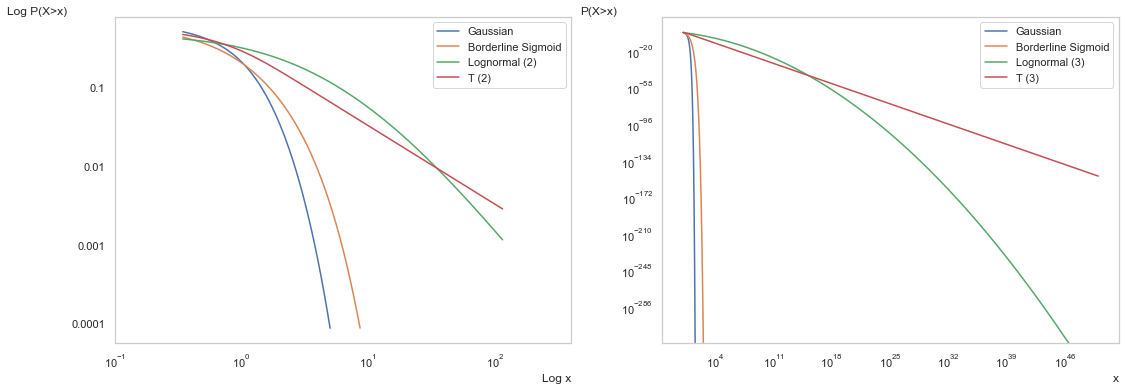

In [82]:
k, df = 3, 2
lognorm = scist.lognorm(s=k)
t = scist.t(df=df)

x = np.logspace(.15, 50,100000, dtype=np.float128)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,6))

with np.errstate(divide='ignore'):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax1.plot(np.log(x), -np.log(scist.norm.pdf(x, scale=1)), label='Gaussian')
        ax1.plot(np.log(x), -np.log(bline.pdf(x)), label='Borderline Sigmoid')
        ax1.plot(np.log(x), -np.log(lognorm.pdf(x)), label='Lognormal (2)')
        ax1.plot(np.log(x), -np.log(t.pdf(x)), label='T (2)')

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlim((0.1, 400))
ylim = ax1.get_ylim()
ax1.set_ylim(ylim[::-1])

yticks = ax1.get_yticks()
ax1.set_yticks(yticks[2:-2])
ax1.set_yticklabels(1/yticks[2:-2])

ax1.set_ylabel('Log P(X>x)', loc='top', rotation='horizontal')
ax1.set_xlabel('Log x', loc='right')

ax1.legend()

with np.errstate(divide='ignore'):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax2.plot(x, scist.norm.pdf(x, scale=1), label='Gaussian')
        ax2.plot(x, bline.pdf(x), label='Borderline Sigmoid')
        ax2.plot(x, lognorm.pdf(x), label='Lognormal (3)')
        ax2.plot(x, t.pdf(x), label='T (3)')

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2.set_ylabel('P(X>x)', loc='top', rotation='horizontal')
ax2.set_xlabel('x', loc='right')

ax2.legend()

ax1.grid(False)
ax2.grid(False)

plt.show()

We can see from the above that the slope of the Gaussian very quickly tends to infinity. Our borderline distribution mirrors the normal closely but is just barely more fat. The lognormal is more so fat tail, but eventually gives up the ruse. The T, however, reaches a firm linear slope equal to the tail index.

### Scale Invariance ###

The property of a linear slope in the tails of a distribution is known as "scale invariance". It means that for a scalar increase in $x$, the probability of occurence decays at a constant rate. Thin-tailed and non-power law fat tails are "scale variant", meaning that the probability of occurence decays at a increasing rate (tending towards infinity as per above).

This is a remarkably powerful effect, as outcomes far out in the tails of power laws are orders of magnitude *of orders of magnitude* (not a typo) more likely. This is not to say that tail events will occur more often; instead it means that *when tail events do occur, they will be much more dramatic*.

Scale invariance is mathematically defined as:

$$
P(X>x) = L(x)x^{-a}
$$

where $L(x)$ is a slow-varying function defined as:

$$
\lim\limits_{x\to\infty} \frac{L(cx)}{L(x)} = 1
$$

$L(x)$ can simply be replaced with a constant, as per the Pareto distribution:

$$
P(X>x) = x_{min}x^{-a}
$$

If you look closely at the chart below, you can see that the Student's T slope only converges into the Paretian at very, very large $x$.

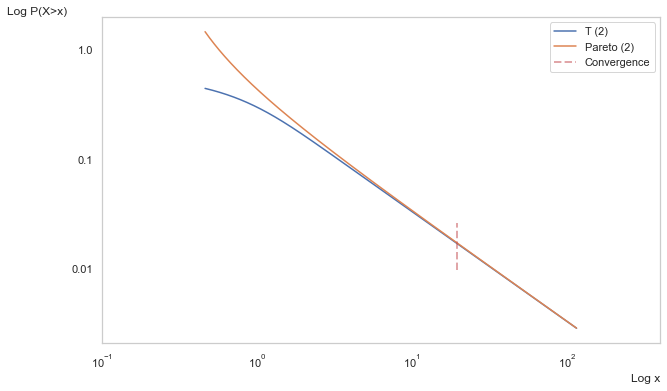

In [83]:
k, df = 3, 2
lognorm = scist.lognorm(s=k)
t = scist.t(df=df)
pareto = scist.pareto(2)

x = np.logspace(.2, 50,100000, dtype=np.float128)
convergence = np.isclose(np.log(t.pdf(x)), np.log(pareto.pdf(x)), atol=1).argmax()

fig, ax2 = plt.subplots(1,1,figsize=(10,6))

ax2.plot(np.log(x), -np.log(t.pdf(x)), label='T (2)')
ax2.plot(np.log(x), -np.log(pareto.pdf(x)), label='Pareto (2)')
ax2.axvline(np.exp(x[convergence]), 
    *(np.exp(-1.5), np.exp(-1)), 
    c='C3', ls='--', lw=2, alpha=.5,
    label='Convergence'
)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2.set_xlim((0.1, 400))
ylim = ax2.get_ylim()
ax2.set_ylim(ylim[::-1])

yticks = ax2.get_yticks()
ax2.set_yticks(yticks[2:-2])
ax2.set_yticklabels(1/yticks[2:-2])

ax2.set_ylabel('Log P(X>x)', loc='top', rotation='horizontal')
ax2.set_xlabel('Log x', loc='right')

ax2.legend()

ax2.grid(False)

plt.show()

We can see this property of scale invariance most clearly in the table below, where we compare the Normal, Lognormal, T, Pareto, and the LogPareto scale ratios at increaseing $k$.

In [7]:
def tail_scale(p, dist):
    return dist.sf(p[1]) / dist.sf(p[0]*p[1])

norm = scist.norm()
lg = scist.lognorm(2)
t = scist.t(2)
pareto = scist.pareto(2)
lp = LogPareto(2)
dists = [norm, lg, t, pareto, lp]

n = [i for i in range(1,5)]
k = [i for i in range(2,16,2)]

index = pd.MultiIndex.from_product([n, k], names=['n', 'k'])

l1 = ['Norm', 'Lognorm', "Student's", 'Pareto', 'Logpareto']
l2 = [r'$P(X > k^{-1})$', r'$\frac{P(X > k)}{P(X > nk)}$']
cols = pd.MultiIndex.from_product((l1,l2))

distcomp = pd.DataFrame([], index=index, columns=cols)
distcomp = distcomp.sort_values(['n', 'k'])

with np.errstate(divide='ignore'):
    for dist, l in zip(dists, l1):
        distcomp.loc[:, (l, l2[0])] = [1 / dist.sf(p[1]) for p in index]
        distcomp.loc[:, (l, l2[1])] = [tail_scale(p, dist) for p in index]

cols_arr = np.array([[j for j in i] for i in distcomp.columns.to_numpy()])
fmt1 = {tuple(col): "{:,.0E}" for col in distcomp.columns[:2]}
fmt2 = {tuple(col): "{:,.0f}" for col in distcomp.columns[[4, 6, 7]]}
fmt3 = {tuple(col): "{:,.1f}" for col in distcomp.columns[[5, 8, 9]]}

distcomp.style.format({**fmt1, **fmt2, **fmt3})

Above we can see that the LogPareto scale ratio is not only scale invariant at large $k$, it is also invariant to $n$!!! Or at least it tends there over time.

This means $\alpha\to0$ as $x\to\infty$, as can be seen below.

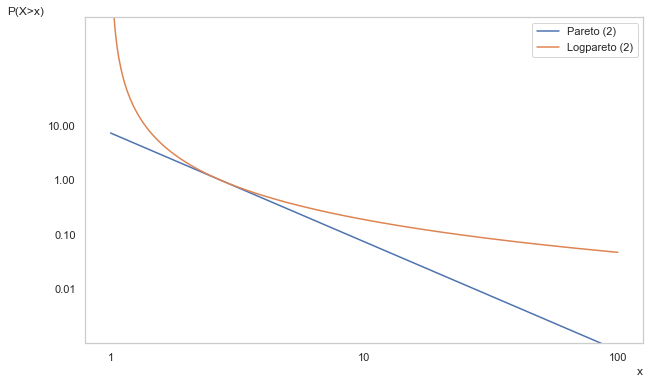

In [91]:
alpha = 2
L = 1
pareto = scist.pareto(alpha, scale=L)
lp = LogPareto(alpha=alpha, L=L)
x = np.linspace(1, 100,10000)

fig, ax = plt.subplots(figsize=(10,6))

with np.errstate(divide='ignore'):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.plot(x, pareto.sf(x)*np.exp(alpha), label='Pareto (2)')
        ax.plot(x, lp.sf(x), label='Logpareto (2)')

ax.set_xscale('log')
ax.set_yscale('log')
yticks = 10**np.arange(-2,2).astype('float')
ax.set_yticks(yticks)
ax.set_yticklabels(1/yticks[2:-2])
ax.set_ylim((10**-3, 10**3))

ax.xaxis.set_major_formatter(mticks.StrMethodFormatter('{x:.0f}'))
ax.yaxis.set_major_formatter(mticks.StrMethodFormatter('{x:.2f}'))

ax.set_ylabel('P(X>x)', loc='top', rotation='horizontal')
ax.set_xlabel('x', loc='right')

ax.legend()
ax.grid(False)

plt.show()

## Simulation w Standard Fat Tails ##

### Why Fat Tails? ###

First, why do we need to simulate using fat tails? ... Because share price movements and many other natural phenomena very likely follow fat tail and power law processes.

In a normal distribtion, per the table above, a so-called "Six Sigma" event (i.e. one that is 6 standard deviations from the mean), should occur two in every $10^9$ samples. For the log returns of daily share prices, this translates into a "Six Sigma" event occuring ***every ~8 million years***.

And yet if you are even 10 years old, you've lived long enough to see a "Six Sigma" event in the stock market. And if you've lived 80 years, well ... We can see this in the log daily returns of the S&P 500 below:

In [9]:
sp = yf.download('^GSPC')
sp_lret = log_returns(sp.Close)

[*********************100%***********************]  1 of 1 completed


/Users/spindicate/Documents/programming/envs/invenv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/spindicate/Documents/programming/envs/invenv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/spindicate/Documents/programming/envs/invenv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/

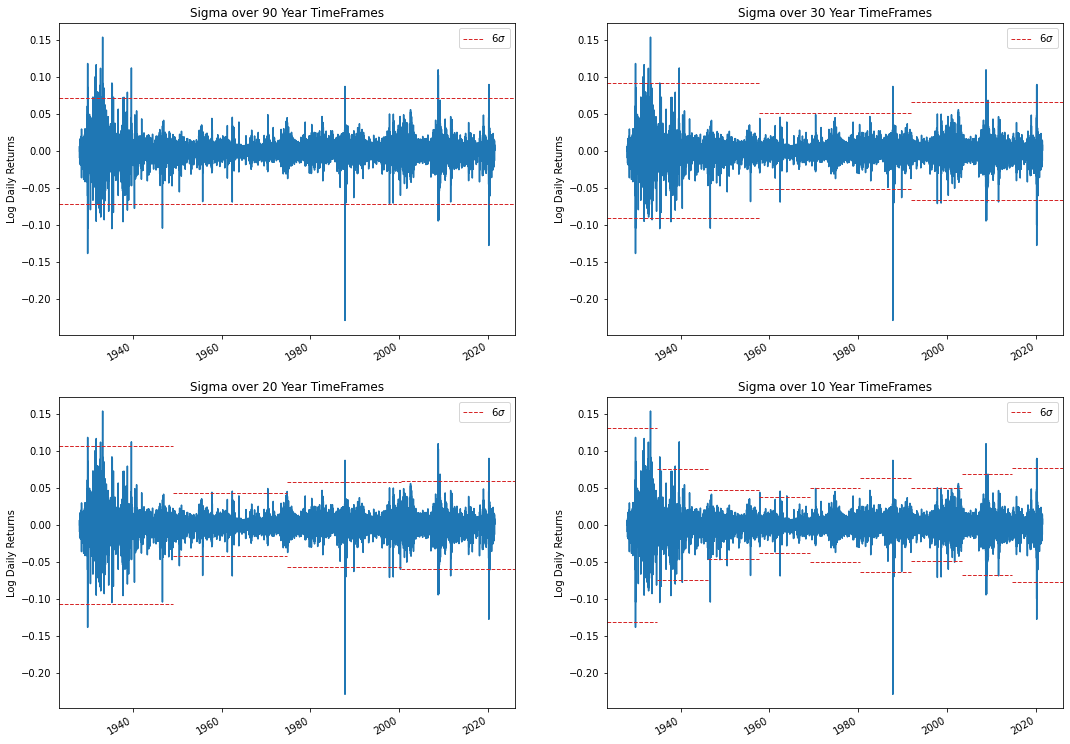

In [10]:
fig, axs = plt.subplots(2,2, figsize=(18,14))
axs = axs.flatten()

rngs = np.arange(30, 0, -10)
rngs = np.concatenate(([90], rngs))
titles = [f'Sigma over {rng} Year TimeFrames' for rng in rngs]
for i in range(4):
    sp_lret.plot(ax=axs[i])

    yrs = np.arange(sp_lret.index.min().year, sp_lret.index.max().year, rngs[i])
    yrs = np.array([dt(yr, 1, 1) for yr in yrs])

    ranges = np.vstack((yrs[:-1], yrs[1:])).T

    stds = []
    for rng in ranges:
        sp_split = sp_lret[slice(*rng)]
        mean, std = scist.norm.fit(sp_split)
        stds.append(std)

    cum = np.concatenate((np.zeros(1), np.repeat(1 / len(stds), len(stds)).cumsum()))
    trng = np.vstack((cum[:-1], cum[1:])).T
    for j in range(len(stds)):
        sig = axs[i].axhline(stds[j]*6, *trng[j], c='C3', ls='--', lw=1, label=r'$6\sigma$')
        signeg = axs[i].axhline(-stds[j]*6, *trng[j], c='C3', ls='--', lw=1, label=r'$-6\sigma$')

    axs[i].set_xlabel('')
    axs[i].set_ylabel('Log Daily Returns')
    axs[i].legend(handles=[sig])
    axs[i].set_title(titles[i])
plt.show()

To paraphrase Taleb:

> If you see a 6 sigma event, that's not a 6 sigma event.

Daily share price returns are clearly ***not*** Gaussian, which has one major implication: Geometric Brownian Motion is not appropriate for share prices and by extension the Black-Scholes pricing model is utterly invalid. 

How does it feel to have paid \$50K+ on a university eduation only to have everything you learned thrown in the trash in 500 words?

### Which Tails? ###

As you may have noted, the simplest power laws adhering to the defintion above cannot have two tails. If $\alpha > 0$, then $f(x)$ cannot have a negative value. Student's T is two-tailed but does not satisfy scale invariance at some of the preasymptotic levels.

Daily share price returns, however, are two-tailed. AND the more extreme tail events seem to occur in the left tail.

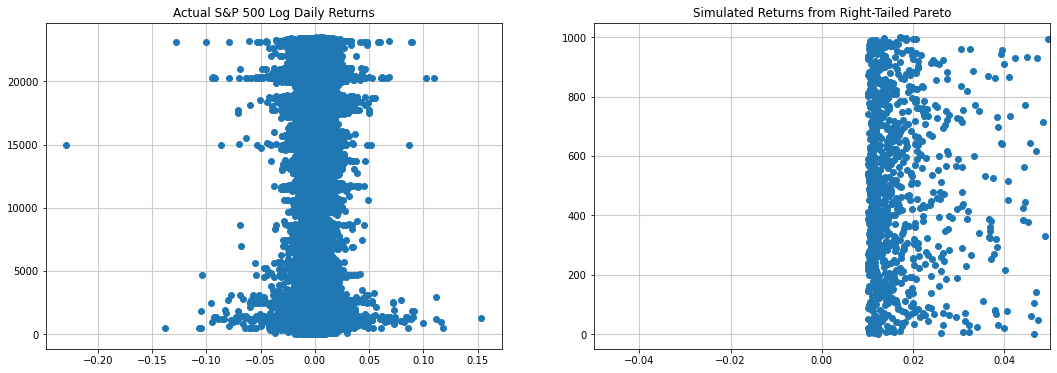

In [69]:
shape = 2
L = .01
pareto = scist.pareto(shape, scale=L)
n = 1000
logrets = pareto.rvs(n)
rets = np.exp(logrets) - 1

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))

ax1.scatter(sp_lret, np.arange(sp_lret.shape[0]))
ax2.scatter(rets, np.arange(n))
ax2.set_xlim((-0.05, .05))

ax1.set_title('Actual S&P 500 Log Daily Returns')
ax2.set_title('Simulated Returns from Right-Tailed Pareto')

plt.show()

One approach is to combine two Paretos, reflecting one so that it is left-tailed. This is available as the `DBLGP` class in the package and looks like the following:

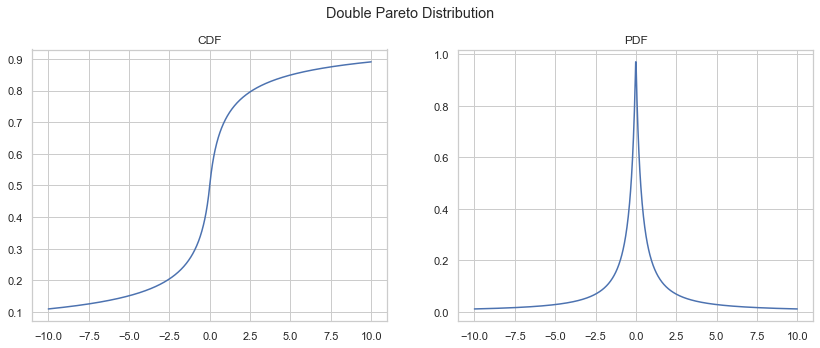

In [70]:
dbl = DBLGP()
shape = 2
x = np.linspace(-10, 10,1000)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))

ax1.plot(x, dbl.cdf(x, shape))
ax2.plot(x, dbl.pdf(x, shape))

ax1.set_title('CDF')
ax2.set_title('PDF')

plt.suptitle('Double Pareto Distribution', y=1)
plt.show()

The DBLGP class is built on two generalized pareto distributions as parameterized in Scipy. The "shape" parameter utilized is the inverted tail index. So a tail index $\alpha = 2$ is equivalent to $\text{shape} = .5$.

DBLGP sublcasses scipy's `rv_continuous`; the usual Scipy methods are available (though all the parameters must be passed at each method call).

Below we can see both the CDF and PPF functions of DBLGP track the summation of its components. The PPF chart has a `logsym` scale on the y-axis, which is awkwardly looking but allows log scale for both negative and positive values.

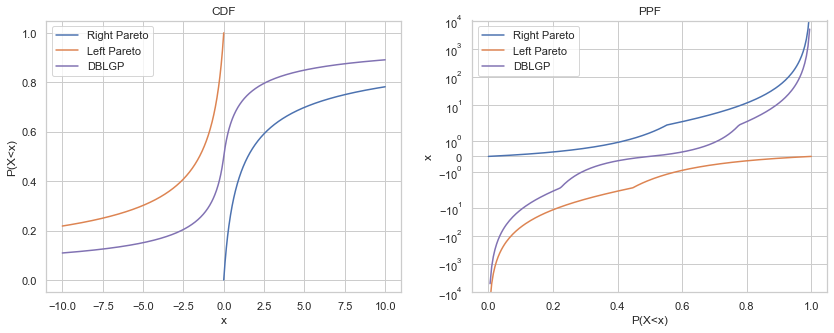

In [71]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,5))

xp = np.linspace(0,10,500)

ax1.plot(xp, scist.genpareto.cdf(xp, shape), label='Right Pareto')
ax1.plot(-xp, scist.genpareto.sf(xp, shape), label='Left Pareto')
ax1.plot(x, dbl.cdf(x, shape), c='C4', label='DBLGP')

ax1.set_xlabel('x')
ax1.set_ylabel('P(X<x)')

qs = np.linspace(0,1,200)
ax2.plot(qs, scist.genpareto.ppf(qs, shape), label='Right Pareto')
ax2.plot(qs, -scist.genpareto.isf(qs, shape), label='Left Pareto')
ax2.plot(qs, dbl.ppf(qs, shape), c='C4', label='DBLGP')

ax2.set_yscale('symlog')
ax2.set_ylim((-10000,10000))

ax2.set_xlabel('P(X<x)')
ax2.set_ylabel('x')

ax1.legend()
ax2.legend()

ax1.set_title('CDF')
ax2.set_title('PPF')
plt.show()

We can easily define a distribution that produces "stock-like" price movements. We assume:

+ $shape = .25$, corresponding to tail index, $\alpha$ of 4
+ scale constant $L=.01$. In the generalized Pareto, this scale constant is analogous to the $L(x)$ slowly-varying function found in the general Power law form.
+ simulation period of 252 trading days

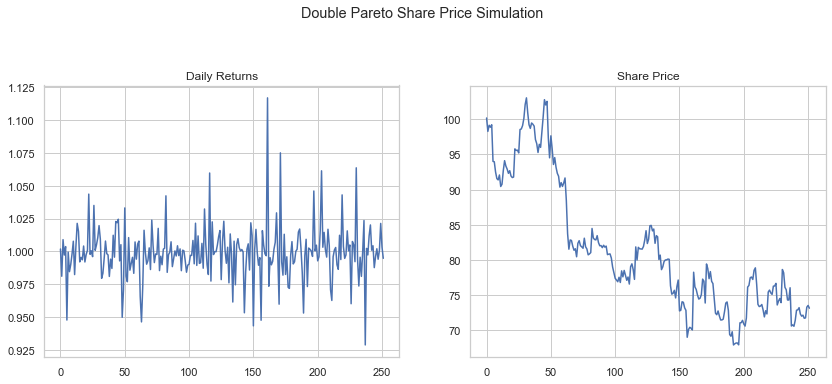

In [72]:
days = 252
x = np.arange(days)
shape = 1/4
L = .01
dbl = DBLGP()

logrets = dbl.rvs(size=x.shape, shape=shape, scale=L)
rets = np.exp(logrets)
S0 = 100
S = S0*rets.cumprod()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))

ax1.plot(x, rets.reshape(-1,1))
ax2.plot(x, S)

ax1.set_title('Daily Returns')
ax2.set_title('Share Price')

plt.suptitle('Double Pareto Share Price Simulation', y=1.1)
plt.show()

As we can see this double Pareto creates price movement that at least looks quite similar to what we'd expect from a share price.

## Estimating Parameters via Threshold Excesses ##

Fat tails are difficult to estimate almost by definition. Because tail events are so infrequent and can be so dramatic, it is effectively impossible to know what distribution is in the tails. And even if we did know the distribution, the limited data points render the usual statistical methods useless for estimating parameters. Hence why Taleb discourages projecting or forecasting of fat tail processes, instead suggesting a focus on heuristics and approximate approaches to assess risk/reward.

Still, without *some* kind of model, it's difficult to even make approximate assessments, so we will forge ahead. 

[Coles (2001, Ch. 4)](https://www.springer.com/gp/book/9781852334598) outlines what appears to be the most accepted method for parameter estimation of fat tails: Threshold Modeling. The approach involves a fair amount of visual interpretation and subjective analysis relative to more common statistical methods. The Threshold Modeling approach agrees in particular with the generalized Pareto.

The process is outlined as follows:

+ the goal is to find some threshold of X, above which a fat tail will apply. this threshold is equivalent to the location parameter of the generalized Pareto.
+ for reasons detailed in Coles, the conditional expectation of X exceeding some threshold is linear in the threshold:

$$
E(X - \theta | X > \theta) = \frac{\sigma_{\theta_o} + \epsilon\theta}{1 - \epsilon}
\\\text{where: } \theta = \text{ the threshold value}
\\\epsilon, \text{ the shape parameter} = 1 / \alpha
\\\sigma, \text{ the scale parameter}
$$

+ because of this linear relationship, we can inspect a Mean Residual Life (MRL) plot for linearity of the mean excesses over a range of thresholds. this linearity would evidence a transition into a generalized Pareto distribution.
+ we then fit the shape and scale parameters to the threshold excesses over a range of thresholds. the favored threshold occurs at the greatest threshold that continues to evidence low variability and tighter confidence bands.
+ with the above, we can select a single threshold value and inspect visually the fit of the CDF, the Return Value / Period, the QQ Plot, and the PP Plot. the closer the data fits with the regression line and confidence bands in the extreme tails, the better the threshold estimate.

This package contains code adpated from the [excellent `thresholdmodeling` package](https://github.com/iagolemos1), with some edge improvements in data structures, etc.

### Threshold Modeling of Daily Rain Data ###

We will walk through a sample of threshold estimate process. First, we will downloand some data from the `thresholdmodeling` package:

In [73]:
from thresholdmodeling import thresh_modeling
from analysis.options.pricing.thold import Threshold

url = 'https://raw.githubusercontent.com/iagolemos1/thresholdmodeling/master/dataset/rain.csv' #saving url
df =  pd.read_csv(url, error_bad_lines=False)
data = df.values.ravel()

First order of business is prepare the Mean Residual Life plot. We are looking for evidence of a linear relationship betwen the mean threshold excesses and the threshold selected. An appropriate threshold might be where this line begins.

In our tools, we have included a `splits` keyword. It accepts an array of floats as x-axis endpoints to line segments on the plot and will provide linear regression statistics for each line created by those endpoints.

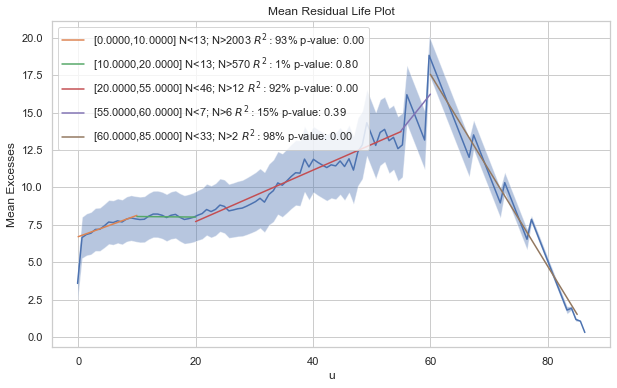

In [74]:
thold = Threshold(data)
splits = [0, 10, 20, 55, 60, 85]
thold.MRL(splits=splits)
plt.show()

../../../../analysis/options/pricing/thold.py:123: RuntimeWarning: invalid value encountered in double_scalars
  CI_mod_scale.append((Var_mod_scale**0.5)*z)


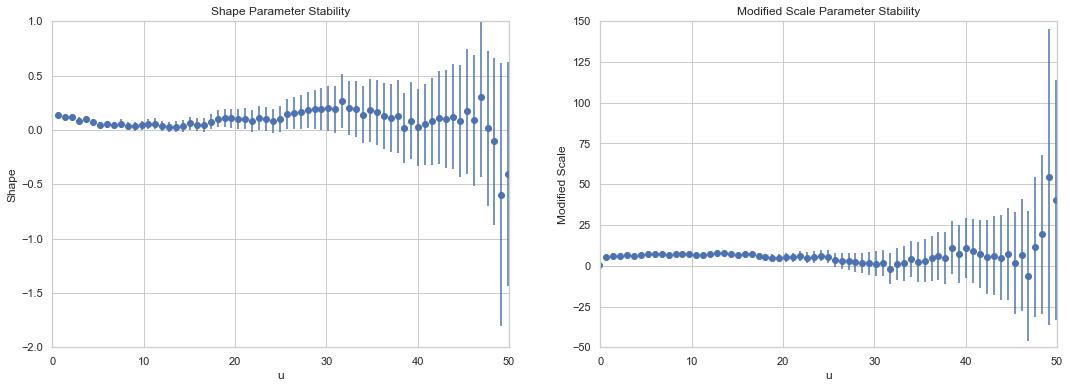

In [21]:
fig, axs = plt.subplots(1,2,figsize=(18,6))
thold.param_stable(spacer=20, fig=fig, axs=axs)
axs[0].set_xlim((0,50))
axs[0].set_ylim((-2,1))
axs[1].set_xlim((0,50))
axs[1].set_ylim((-50,150))
plt.show()

../../../../analysis/options/pricing/thold.py:178: RuntimeWarning: invalid value encountered in double_scalars
  CI_qq_high.append(thold + ((scale/shape)*(((1-((F2)/(1)))**-shape) - 1)))


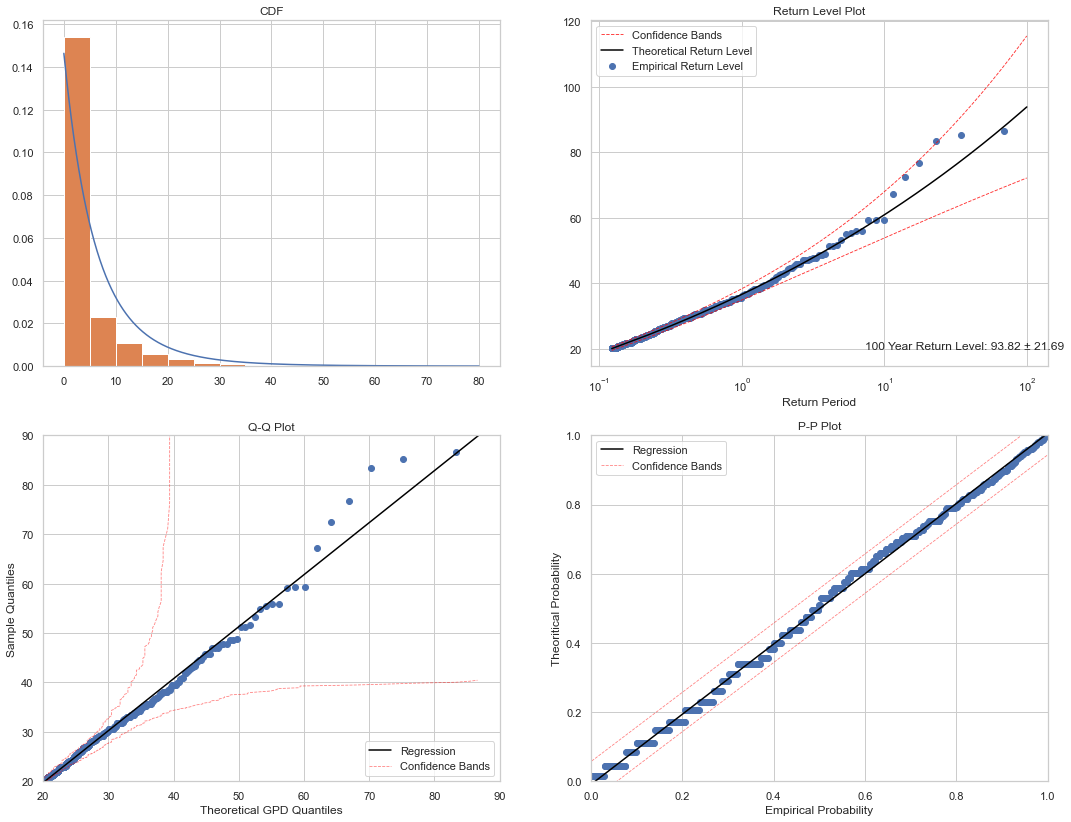

In [22]:
fit, _, over_thresh = thold.fit(thold=20)
scale, shape = fit[0][0], fit[0][1]

x = np.linspace(0, 80, 1000)

fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,14))

ax1.plot(x, scist.genpareto.pdf(x, shape, scale=scale), label='Fitted PDF')
counts, bins, _ = ax1.hist(data, bins=np.arange(0,80,5), density=True, label='Data')
ax1.set_title('CDF')

thold.return_value(thold=20, fig=fig, ax=ax2)

thold.qqplot(thold=20, fig=fig, ax=ax3)
thold.ppplot(thold=20, fig=fig, ax=ax4)

ax3.set_xlim((20,90))
ax3.set_ylim((20,90))

ax4.set_xlim((0,1))
ax4.set_ylim((0,1))

plt.show()

### Threshold Modeling: S&P500 ###

Now we'll turn the approach once again to the daily log returns of the S&P 500. These returns are again *two-tailed*, so we must find parameters for both tails. There are several approaches we can take, none of which are ideal:

1. Take absolute values and apply the resulting parameters in both tails
2. Take the values as is, finding the right tail parameters, then flip and find the left tail parameters. A symmetric distribution could be created from the average of the two or an assymetric one could utilize separate params in each tail.
3. Split the data into separate subsets, one postive and one negative and fit each dataset.

Currently, DBLGP supports only one set of Pareto parameters, so we will implement for a symmetric distribution.

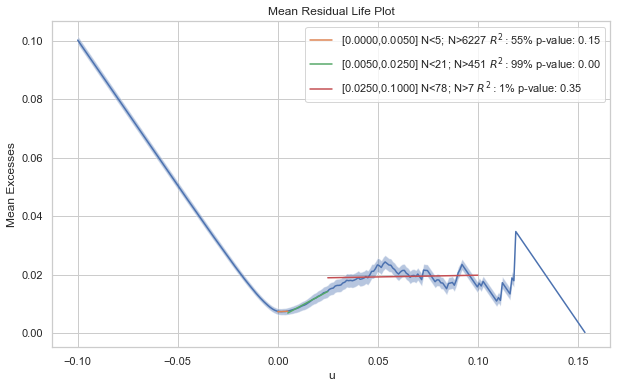

In [23]:
thold = Threshold(sp_lret)
splits = [0, .005, .025, .1]
thold.MRL(splits=splits)
plt.show()

The residuals plot doesn't provide as clear an indication with this dataset, although .5% continuous return is a good starting point. The parameter stability as both the shape and scale paramters are invariant well past .5%.

../../../../analysis/options/pricing/thold.py:123: RuntimeWarning: invalid value encountered in double_scalars
  CI_mod_scale.append((Var_mod_scale**0.5)*z)


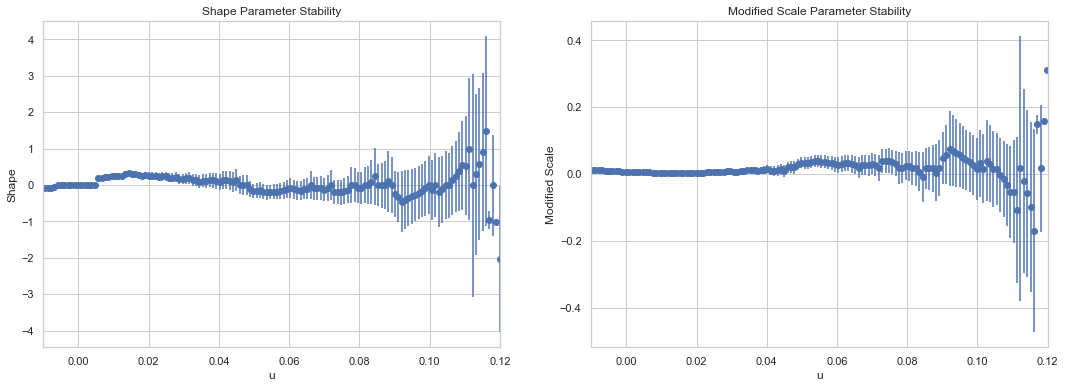

In [24]:
fig, axs = plt.subplots(1,2,figsize=(18,6))
thold.param_stable(spacer=5, fig=fig, axs=axs)
axs[0].set_xlim((-0.01, .12))
axs[1].set_xlim((-0.01, .12))
plt.show()

Both parameters are quite stable out to 3% and even beyond. So without anything more conclusive, we will fit two separate Paretos on either end of the range: 

$loc_1 = .02$ 
and 
$loc_2 = .005$

../../../../analysis/options/pricing/thold.py:178: RuntimeWarning: invalid value encountered in double_scalars
  CI_qq_high.append(thold + ((scale/shape)*(((1-((F2)/(1)))**-shape) - 1)))


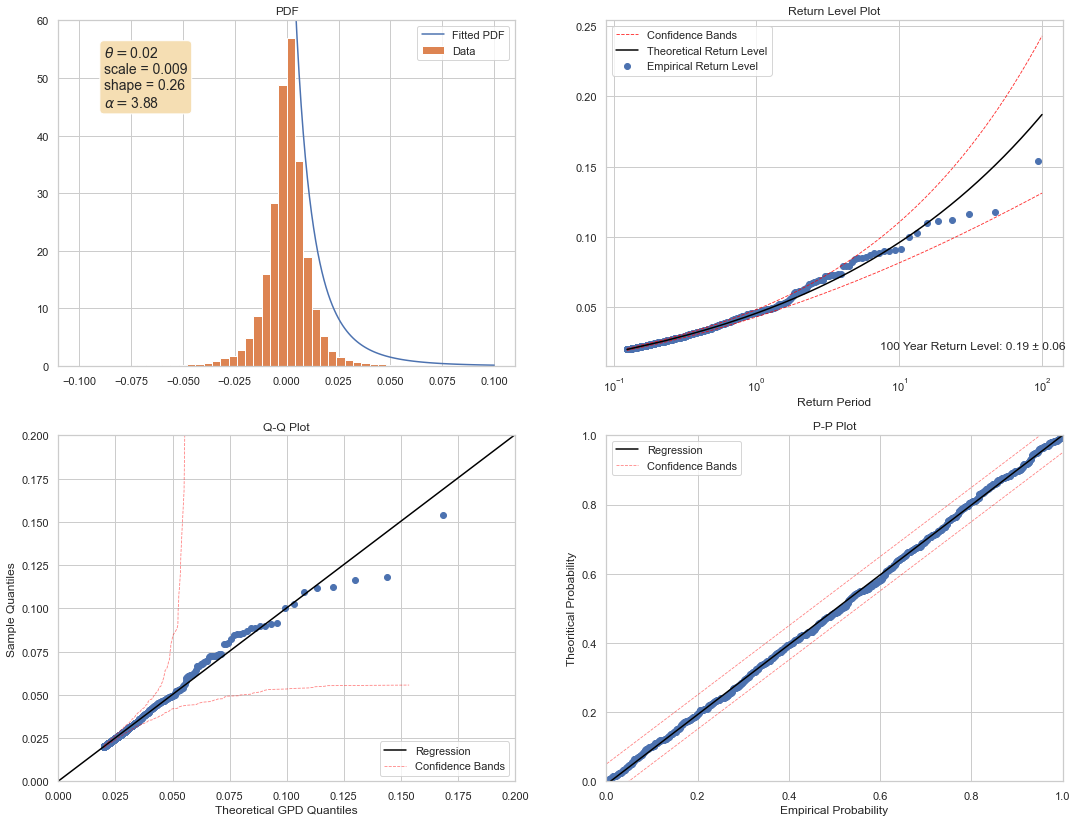

In [25]:
thresh = 0.02
fit, _, over_thresh = thold.fit(thold=thresh)
scale, shape = fit[0][0], fit[0][1]

x = np.linspace(0, .1, 101)

fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,14))

ax1.plot(x, scist.genpareto.pdf(x, shape, scale=scale), label='Fitted PDF')
counts, bins, _ = ax1.hist(thold.data, bins=np.linspace(-.1,.1,51), density=True, label='Data')

txt = r'$\theta = $' + f'{thresh}'
txt += '\n'
txt += f'scale = {scale:.3f}'
txt += '\n'
txt += f'shape = {shape:.2f}'
txt += '\n'
txt += r'$\alpha = $' + f'{1/shape:.2f}'
props = dict(boxstyle='round', facecolor='wheat')
ax1.text(.1, .75, txt, transform=ax1.transAxes, fontsize=14, bbox=props)

ax1.set_ylim((0, 60))
ax1.set_title('PDF')
ax1.legend()

thold.return_value(thold=thresh, fig=fig, ax=ax2)

thold.qqplot(thold=thresh, fig=fig, ax=ax3)
thold.ppplot(thold=thresh, fig=fig, ax=ax4)

ax3.set_xlim((0,.2))
ax3.set_ylim((0,.2))

ax4.set_xlim((0,1))
ax4.set_ylim((0,1))

plt.show()

../../../../analysis/options/pricing/thold.py:178: RuntimeWarning: invalid value encountered in double_scalars
  CI_qq_high.append(thold + ((scale/shape)*(((1-((F2)/(1)))**-shape) - 1)))


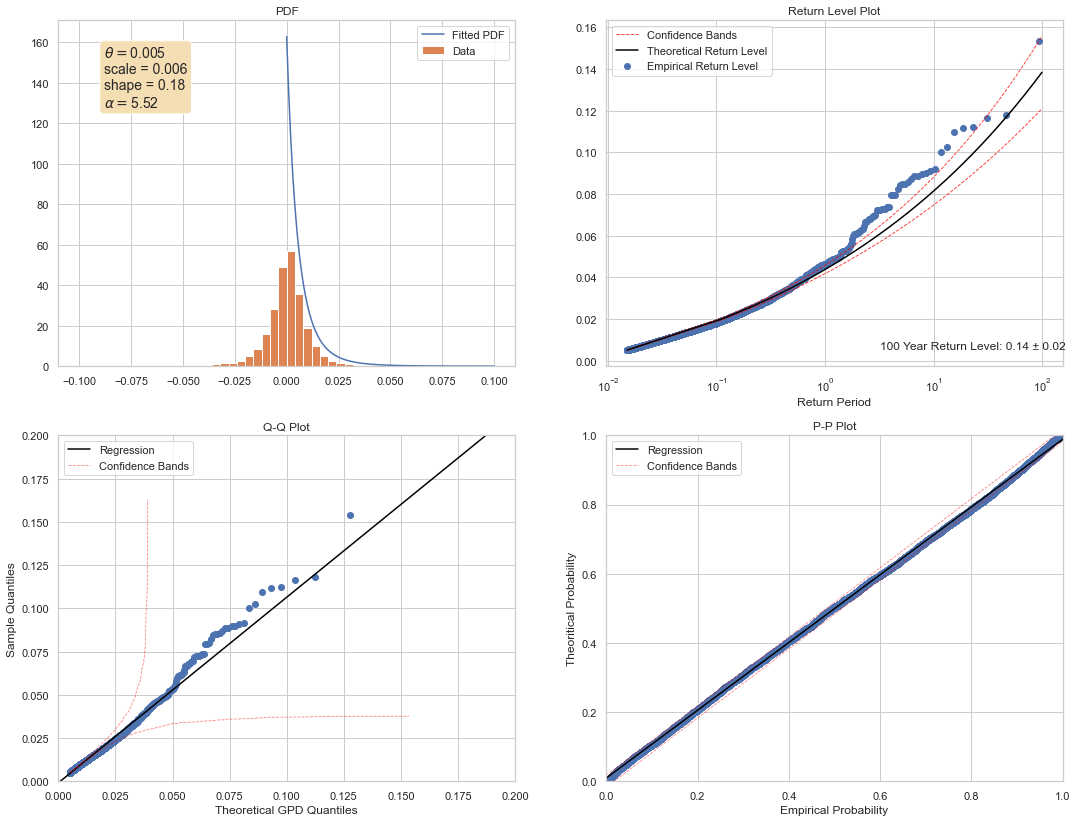

In [26]:
thresh = .005
fit, _, over_thresh = thold.fit(thold=thresh)
scale, shape = fit[0][0], fit[0][1]

x = np.linspace(0, .1, 101)

fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,14))

ax1.plot(x, scist.genpareto.pdf(x, shape, scale=scale), label='Fitted PDF')

counts, bins, _ = ax1.hist(thold.data, bins=np.linspace(-.1,.1,51), density=True, label='Data')

# ax1.set_ylim((0, 60))
ax1.set_title('PDF')
ax1.legend()

txt = r'$\theta = $' + f'{thresh}'
txt += '\n'
txt += f'scale = {scale:.3f}'
txt += '\n'
txt += f'shape = {shape:.2f}'
txt += '\n'
txt += r'$\alpha = $' + f'{1/shape:.2f}'
props = dict(boxstyle='round', facecolor='wheat')
ax1.text(.1, .75, txt, transform=ax1.transAxes, fontsize=14, bbox=props)

thold.return_value(thold=thresh, fig=fig, ax=ax2)

thold.qqplot(thold=thresh, fig=fig, ax=ax3)
thold.ppplot(thold=thresh, fig=fig, ax=ax4)

ax3.set_xlim((0,.2))
ax3.set_ylim((0,.2))

ax4.set_xlim((0,1))
ax4.set_ylim((0,1))

plt.show()

Right away we can see a trade-off between the two thresholds:

+ the higher threshold provides a better fit deeper in the tails, however, the body is less appropriate
+ the lower threshold is a worse fit deep in the tails, however, the body is a closer fit

As discussed, we'll use the fitted parameters in both tails of our double Pareto to simulate a share price movement, which we overlay over the dataset below.

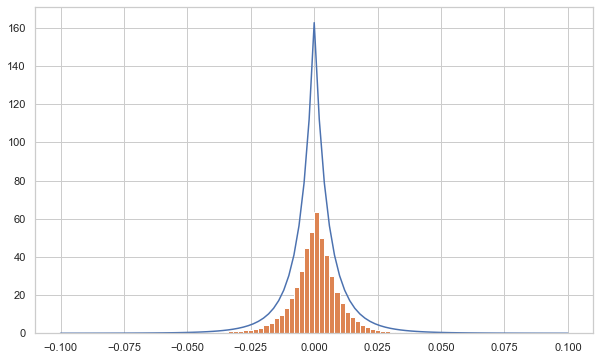

In [27]:
dbl = DBLGP()

x = np.linspace(-.1, .1, 101)

fig, ax = plt.subplots(1,1,figsize=(10,6))

ax.plot(x, dbl.pdf(x, shape, scale=scale), label='Fitted PDF')
counts, bins, _ = ax.hist(thold.data, bins=np.linspace(-.1,.1,101), density=True, label='Data')

ax1.set_title('PDF')

plt.show()

Below is a single sample path:

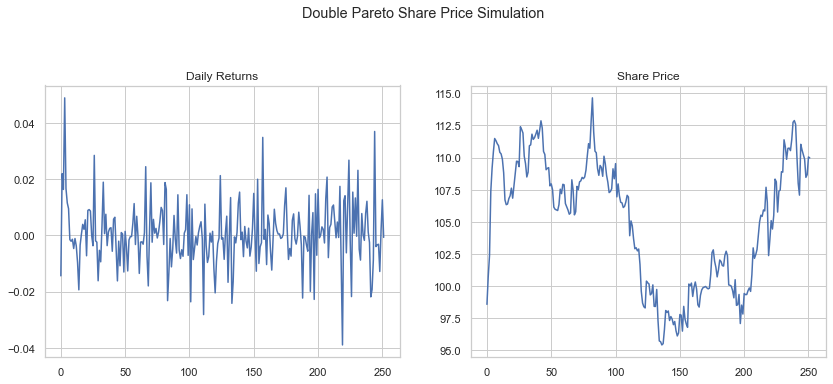

In [28]:
days = 252
x = np.arange(days)
logrets = dbl.rvs(size=x.shape, shape=shape, scale=scale)
rets = np.exp(logrets)
S0 = 100
S = S0*rets.cumprod()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))

ax1.plot(x, (rets - 1).reshape(-1,1))
ax2.plot(x, S)

ax1.set_title('Daily Returns')
ax2.set_title('Share Price')

plt.suptitle('Double Pareto Share Price Simulation', y=1.1)
plt.show()

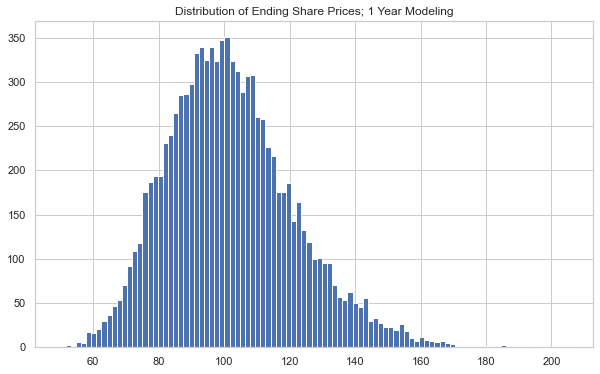

In [29]:
n = 10000
x = np.arange(days)
dbl = DBLGP()

logrets = dbl.rvs(shape, scale=scale, size=(n, days))
rets = np.exp(logrets) - 1
S0 = 100
S = S0*np.exp(logrets).cumprod(axis=1)

fig, ax = plt.subplots(1,1,figsize=(10,6))

counts, bins, _ = ax.hist(S[:, -1], bins=np.linspace(50, S[:, -1].max(), 100))

ax.set_title('Distribution of Ending Share Prices; 1 Year Modeling')
plt.show()

## Simulation Using Hybrids ##

### The Carben Hybrid ###

As we saw above, the double Pareto can perform well in the tails but it is a poor model of price changes in the body. 

One approach to addressing this issue is to just ignore it. Taleb would say all the impact is in the tails anyway, so the action in the body can simply be ignored. Fine, but our modelling *should* be improved if we can improve the performance in the body.

So another approach is to combine two distributions; one for the body and one for the tail. [Carreau and Bengio](https://www.researchgate.net/publication/226293435_A_hybrid_Pareto_model_for_asymmetric_fat-tailed_data_The_univariate_case) propose an approach for grafting a pareto distribution onto the tail of a normal distribution.

We have replicated the strategy in the CarBenHybrid class. The Carben Hybrid is a one-tailed distribution, but later we will mix them to create a two-tailed.

Below we give details on its construction.

A hybrid of the Gaussian and Pareto distributions has several important properties:

1. the combination of distributions is described by 5 parameters
    + $\mu$ and $\sigma$ for the normal
    + $m$, $s$, and $\epsilon$ representing location, scale, and shape of the Pareto tail
    + as we'll see, two necessary equalities reduces the number of free parameters to 3

2. the junction point between the two distributions is the location parameter, $m$, of the Pareto tail, such that:

$$ 
f(X=m) = g(X=0) 
$$
where:
$$
\\f(X) \text{ is gaussian}
\\g(X) \text{ is Pareto}
\\ m = \text{location parameter of the Pareto tail}
$$

3. the derivatives of each distribution at the junction point are also equal:

$$ 
f'(X=m) = g'(X=0) 
$$

4. from (2) and (3) above, the location and scale parameters of the Pareto can be find as follows (see Carreau for derivation):

$$
\\s = \frac{\sigma(1 + \epsilon)}{\sqrt{W(z)}}
\\m = \mu + \sigma\sqrt{W(z)}
$$
where:
$$
W(z) \text{ is the Lambert W function, and}
\\z = \omega e^{\omega}
$$

So, we have just the following free parameters to estimate:

+ for the gaussian: $\mu$ and $\sigma$
+ for the generalized Pareto: $\epsilon$, which is $= 1/\alpha$, or the inverse of the tail index 

5. a scaling factor, $1 / \gamma$, is applied to both distributions such that the probabilities sum to 1. This scaling is also equivalent to the survival function in tail:

$$ 1 / \gamma = P(X > m) $$

$\gamma$ is computed directly as detailed in Carreau (2008):

$$ \gamma = 1 + \frac{1}{2}(1 + Erf(\sqrt{W(z) / 2})) $$

where: $$ Erf \text{ is the error function}$$

We can see how it all fits together below:

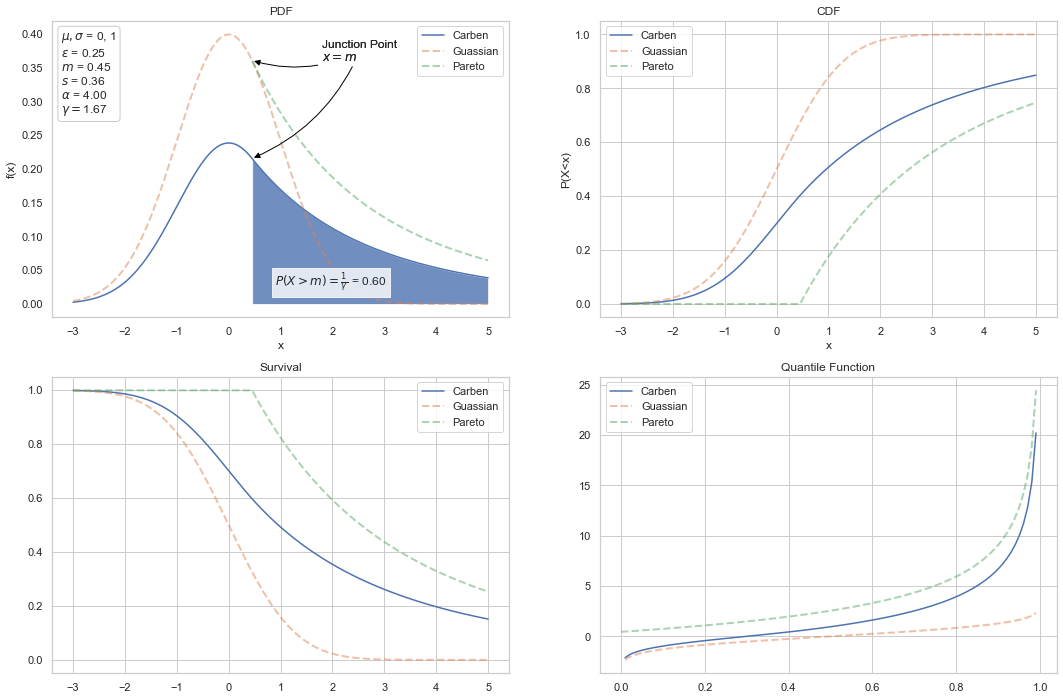

In [31]:
shape, mean, std = 1/4, 0, 1
x = np.linspace(-3, 5, 1000)
dist = CarbenHybrid(x, shape, mean, std)

fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,12))

tailprops = dict(ls='--', lw=2, alpha=.5)
ax1.plot(x, dist.pdf(), label='Carben')
ax1.plot(x, dist.body.pdf(x), label='Guassian', **tailprops)
ax1.plot(x[x>dist.loc], dist.tail.pdf(x[x>dist.loc]), label='Pareto', **tailprops)

paramtxt = r'$\mu, \sigma$ = ' + f'{dist.mean:.0f}, {dist.std:.0f}'
paramtxt += '\n'
paramtxt += r'$\epsilon$ = ' + f'{dist.shape:.2f}'
paramtxt += '\n'
paramtxt += r'$m$ = ' + f'{dist.loc:.2f}'
paramtxt += '\n'
paramtxt += r'$s$ = ' + f'{1 / dist.scale:.2f}'
paramtxt += '\n'
paramtxt += r'$\alpha$ = ' + f'{1 / dist.shape:.2f}'
paramtxt += '\n'
paramtxt += r'$\gamma = $' + f'{dist.gamma:.2f}'
ax1.text(
    .02,.69, paramtxt,
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)

txt = 'Junction Point\n' + r'$x = m$' 
arrowprops = dict(
    arrowstyle="-|>", connectionstyle="arc3,rad=-.2", fc='black', ec='black'
)
ax1.annotate(
    txt, xy=(dist.loc, dist.tail.pdf(dist.loc)), xytext=(dist.loc*4, dist.tail.pdf(dist.loc)),
    arrowprops=arrowprops
)
ax1.annotate(
    txt, xy=(dist.loc, dist.pdf(dist.loc)), xytext=(dist.loc*4, dist.tail.pdf(dist.loc)),
    arrowprops=arrowprops
)

txt = r'$P(X > m) = \frac{1}{\gamma}$ = ' + f'{1 / dist.gamma:.2f}'
ax1.text(
    dist.loc*2, dist.pdf(dist.loc)/8, txt,
    bbox=dict(boxstyle='square', ec='w', fc='w', alpha=.8)
)
ax1.fill_between(x[x>dist.loc], dist.pdf(x[x>dist.loc]), alpha=.8)
ax1.grid(False)
ax2.plot(x, dist.cdf(), label='Carben')
ax2.plot(x, dist.body.cdf(x), label='Guassian', **tailprops)
ax2.plot(x, dist.tail.cdf(x), label='Pareto', **tailprops)

ax3.plot(x, dist.sf(), label='Carben')
ax3.plot(x, dist.body.sf(x), label='Guassian', **tailprops)
ax3.plot(x, dist.tail.sf(x), label='Pareto', **tailprops)

q = np.linspace(0,.99,101)
ax4.plot(q, dist.ppf(q), label='Carben')
ax4.plot(q, dist.body.ppf(q), label='Guassian', **tailprops)
ax4.plot(q, dist.tail.ppf(q), label='Pareto', **tailprops)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')

ax2.set_xlabel('x')
ax2.set_ylabel('P(X<x)')


ax1.set_title('PDF')
ax2.set_title('CDF')
ax3.set_title('Survival')
ax4.set_title('Quantile Function')

plt.show()

And we can generate a set of random variables that fits the distribution perfectly:

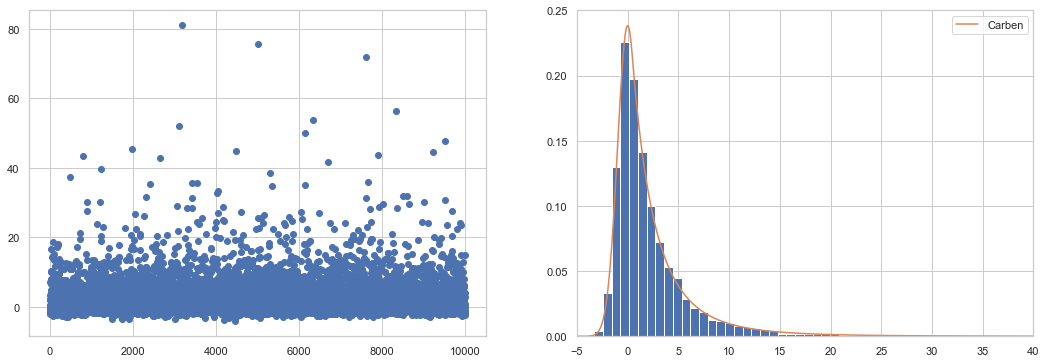

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))
x = np.linspace(-10, 40, 1000)
n = 10000
rvs = dist.rvs(n)
ax1.scatter(np.arange(n), rvs)
ax2.hist(rvs, bins=np.linspace(rvs.min(), rvs.max(), 100), density=True)

ax2.plot(x, dist.pdf(x), label='Carben')
ax2.set_xlim((-5,40))
ax2.legend()

plt.show()

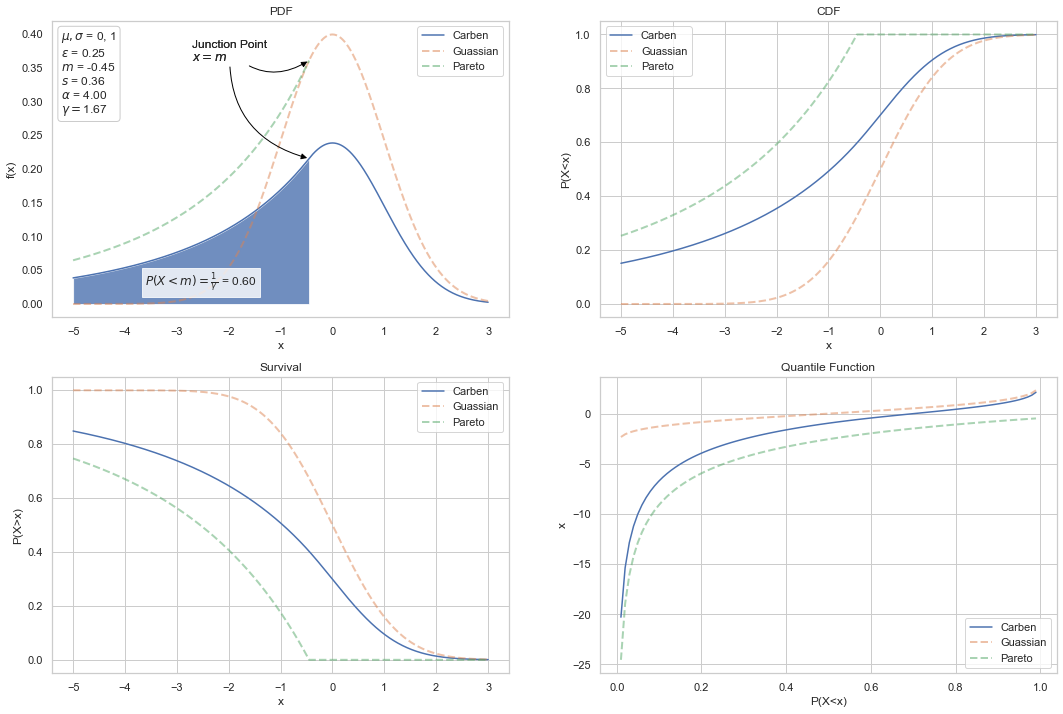

In [35]:
x = np.linspace(-5, 3, 1000)

dist = CarbenHybrid(x, -shape, -mean, std)

fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,12))

tailprops = dict(ls='--', lw=2, alpha=.5)
ax1.plot(x, dist.pdf(), label='Carben')
ax1.plot(x, dist.body.pdf(x), label='Guassian', **tailprops)
ax1.plot(x[x<dist.loc], dist.tail.pdf(-x[x<dist.loc]), label='Pareto', **tailprops)

paramtxt = r'$\mu, \sigma$ = ' + f'{dist.mean:.0f}, {dist.std:.0f}'
paramtxt += '\n'
paramtxt += r'$\epsilon$ = ' + f'{dist.shape:.2f}'
paramtxt += '\n'
paramtxt += r'$m$ = ' + f'{dist.loc:.2f}'
paramtxt += '\n'
paramtxt += r'$s$ = ' + f'{1 / dist.scale:.2f}'
paramtxt += '\n'
paramtxt += r'$\alpha$ = ' + f'{1 / dist.shape:.2f}'
paramtxt += '\n'
paramtxt += r'$\gamma = $' + f'{dist.gamma:.2f}'
ax1.text(
    .02,.69, paramtxt,
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)

txt = 'Junction Point\n' + r'$x = m$' 
arrowprops = dict(
    arrowstyle="-|>", connectionstyle="arc3,rad=.4", fc='black', ec='black'
)
ax1.annotate(
    txt, xy=(dist.loc, dist.tail.pdf(-dist.loc)), xytext=(dist.loc*6, dist.tail.pdf(-dist.loc)),
    arrowprops=arrowprops
)
ax1.annotate(
    txt, xy=(dist.loc, dist.pdf(-dist.loc)), xytext=(dist.loc*6, dist.tail.pdf(-dist.loc)),
    arrowprops=arrowprops
)
txt = r'$P(X < m) = \frac{1}{\gamma}$ = ' + f'{1 / dist.gamma:.2f}'
ax1.text(
    dist.loc*8, dist.pdf(dist.loc)/8, txt,
    bbox=dict(boxstyle='square', ec='w', fc='w', alpha=.8)
)
ax1.fill_between(x[x<dist.loc], dist.pdf(x[x<dist.loc]), alpha=.8)
ax1.grid(False)
ax2.plot(x, dist.cdf(), label='Carben')
ax2.plot(x, dist.body.cdf(x), label='Guassian', **tailprops)
ax2.plot(x, 1 - dist.tail.cdf(-x), label='Pareto', **tailprops)

ax3.plot(x, dist.sf(), label='Carben')
ax3.plot(x, dist.body.sf(x), label='Guassian', **tailprops)
ax3.plot(x, 1 - dist.tail.sf(-x), label='Pareto', **tailprops)

q = np.linspace(0,.99,101)
ax4.plot(q, dist.ppf(q), label='Carben')
ax4.plot(q, dist.body.ppf(q), label='Guassian', **tailprops)
ax4.plot(q, -dist.tail.ppf(1 - q), label='Pareto', **tailprops)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax2.set_xlabel('x')
ax2.set_ylabel('P(X<x)')
ax3.set_xlabel('x')
ax3.set_ylabel('P(X>x)')
ax4.set_xlabel('P(X<x)')
ax4.set_ylabel('x')

ax1.set_title('PDF')
ax2.set_title('CDF')
ax3.set_title('Survival')
ax4.set_title('Quantile Function')

plt.show()

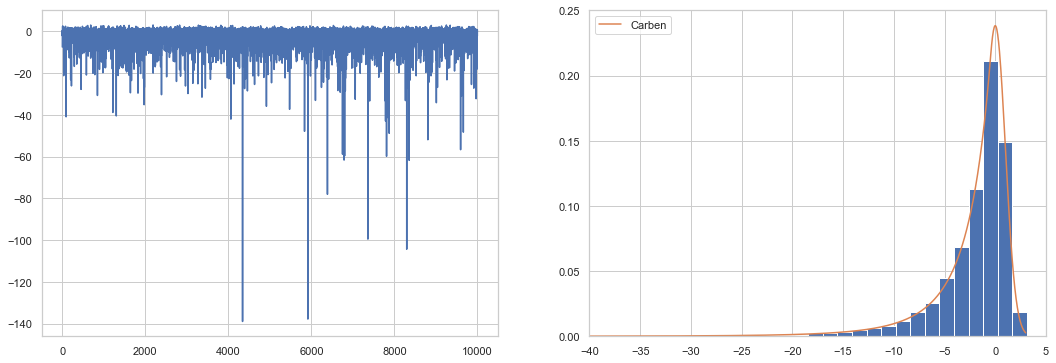

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))
n = 10000
x = np.linspace(-40, 3, 1000)
rvs = dist.rvs(n)
ax1.plot(np.arange(n), rvs)
ax2.hist(rvs, bins=np.linspace(rvs.min(), rvs.max(), 100), density=True)
ax2.plot(x, dist.pdf(x), label='Carben')
ax2.set_xlim((-40,5))
ax2.legend()

plt.show()

### Pareto Hybrids with Asymmetric Tails:  A Mixture Model ###

So, we have a one-tailed hybrid model that *may* be better suited for our data, but as we've discussed, share price returns are two-tailed. In the case of a Carben, a simple solution is mixing between a left-tailed and a right-tailed. If both the left- and right-tailed Carben's have the same characteristics in the body (i.e. the normal distributions are the same), the two will mix interchangeably between the junction points with the only impact of mixing epxerienced in the tails.

Mixing between continuous models is achieved very simple as a weighted average in both the PDF, CDF, and other characteristics, by extension:

$$
F(x) = \sum\limits_{i=1}^nw_iF_i(x)
\\f(x) = \sum\limits_{i=1}^nw_if_i(x)
$$

The mixed model can be made symmetrical by providing the same, but opposite signed, shape parameter, OR each tail can have a unique tail factor as necessary in the data. Thus, the distribution adds only 1 or None new free parameters.

The distribution is accessible via the PHAT model. Again, *two* shape parameters must be provided, first for left and then for right. The default weightings for the two tails is 50/50.

We will show a symmetrical PHAT in our first example, however, one with the gaussian mean shifted positive and with a higher variance.

In [37]:
shape, mean, std = 1/5, 2, 2
x = np.linspace(-10+mean, 10+mean, 1000)
dist1 = PHAT(x, mean, std, shape, shape)

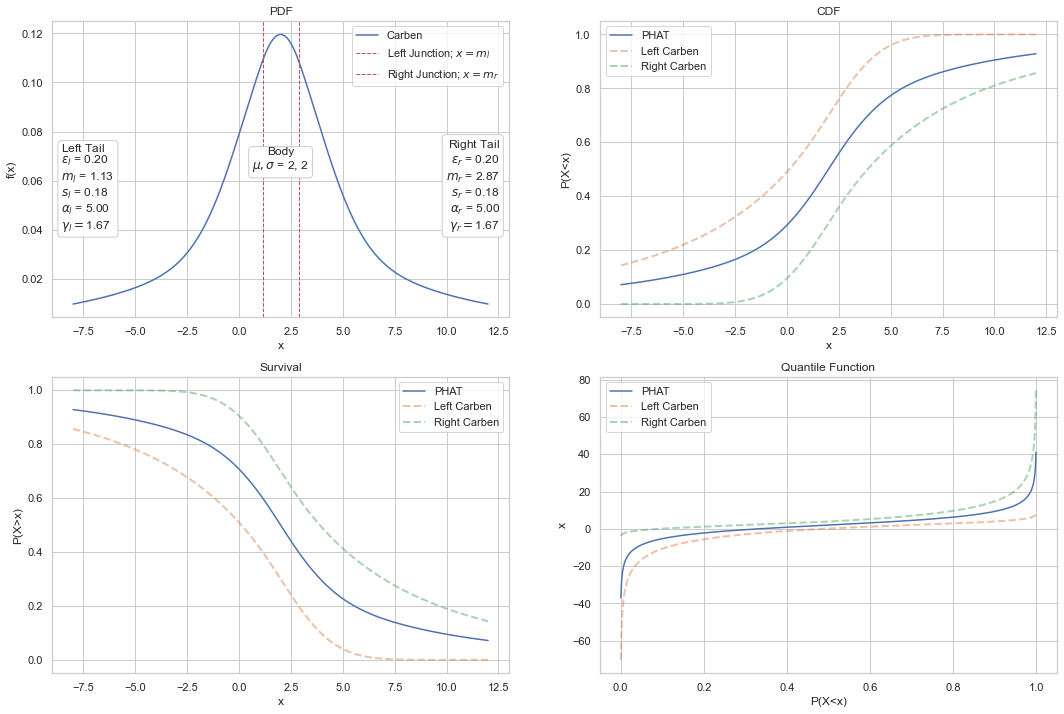

In [38]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(18,12))

ax1.plot(x, dist1.pdf(), label=f'Carben')
ax1.axvline(dist1.left.loc, c='r', ls='--', lw=1, label=r'Left Junction; $x = m_l$')
ax1.axvline(dist1.right.loc, c='r', ls='--', lw=1, label=r'Right Junction; $x = m_r$')

paramtxt = 'Body'
paramtxt += '\n'
paramtxt += r'$\mu, \sigma$ = ' + f'{dist1.mean:.0f}, {dist1.std:.0f}'

ax1.text(
    .5, .5, paramtxt, ha='center',
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)

paramtxt = r'Left Tail$_{}$'
paramtxt += '\n'
paramtxt += r'$\epsilon_{l}$ = ' + f'{dist1.shape_l:.2f}'
paramtxt += '\n'
paramtxt += r'$m_l$ = ' + f'{dist1.left.loc:.2f}'
paramtxt += '\n'
paramtxt += r'$s_l$ = ' + f'{1 / dist1.left.scale:.2f}'
paramtxt += '\n'
paramtxt += r'$\alpha_l$ = ' + f'{1 / dist1.left.shape:.2f}'
paramtxt += '\n'
paramtxt += r'$\gamma_l = $' + f'{dist1.left.gamma:.2f}'

ax1.text(
    .02,.3, paramtxt,
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)
paramtxt = r'Right Tail$_{}$'
paramtxt += '\n'
paramtxt += r'$\epsilon_r$ = ' + f'{dist1.right.shape:.2f}'
paramtxt += '\n'
paramtxt += r'$m_r$ = ' + f'{dist1.right.loc:.2f}'
paramtxt += '\n'
paramtxt += r'$s_r$ = ' + f'{1 / dist1.right.scale:.2f}'
paramtxt += '\n'
paramtxt += r'$\alpha_r$ = ' + f'{1 / dist1.right.shape:.2f}'
paramtxt += '\n'
paramtxt += r'$\gamma_r = $' + f'{dist1.right.gamma:.2f}'

ax1.text(
    .98,.3, paramtxt, ha='right',
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)

tailprops = dict(ls='--', lw=2, alpha=.5)
ax2.plot(x, dist1.cdf(), label='PHAT')
ax2.plot(x, dist1.left.cdf(), label='Left Carben', **tailprops)
ax2.plot(x, dist1.right.cdf(), label='Right Carben', **tailprops)

ax3.plot(x, dist1.sf(), label='PHAT')
ax3.plot(x, dist1.left.sf(), label='Left Carben', **tailprops)
ax3.plot(x, dist1.right.sf(), label='Right Carben', **tailprops)

q = np.linspace(0,.999,1000)
ax4.plot(q, dist1.ppf(q), label='PHAT')
ax4.plot(q, dist1.left.ppf(q), label='Left Carben', **tailprops)
ax4.plot(q, dist1.right.ppf(q), label='Right Carben', **tailprops)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax2.set_xlabel('x')
ax2.set_ylabel('P(X<x)')
ax3.set_xlabel('x')
ax3.set_ylabel('P(X>x)')
ax4.set_xlabel('P(X<x)')
ax4.set_ylabel('x')

ax1.set_title('PDF')
ax2.set_title('CDF')
ax3.set_title('Survival')
ax4.set_title('Quantile Function')

plt.show()

We can see above the properties shared between the left and right tails. Only the location for each tail is different, attributable to the fact that the mean of the normal distribution is to 2.

Below we show an example of two assymetric blends, one with a thinner left tail and one thicker. The right tails of both blends are identical. We can see the thicker tail twists lower thinner near the body, of course, leading to a thicker tail in the extreme.

As we can see, simply by providing different left tail shapes, the tails end up with entirely different parameters overall.

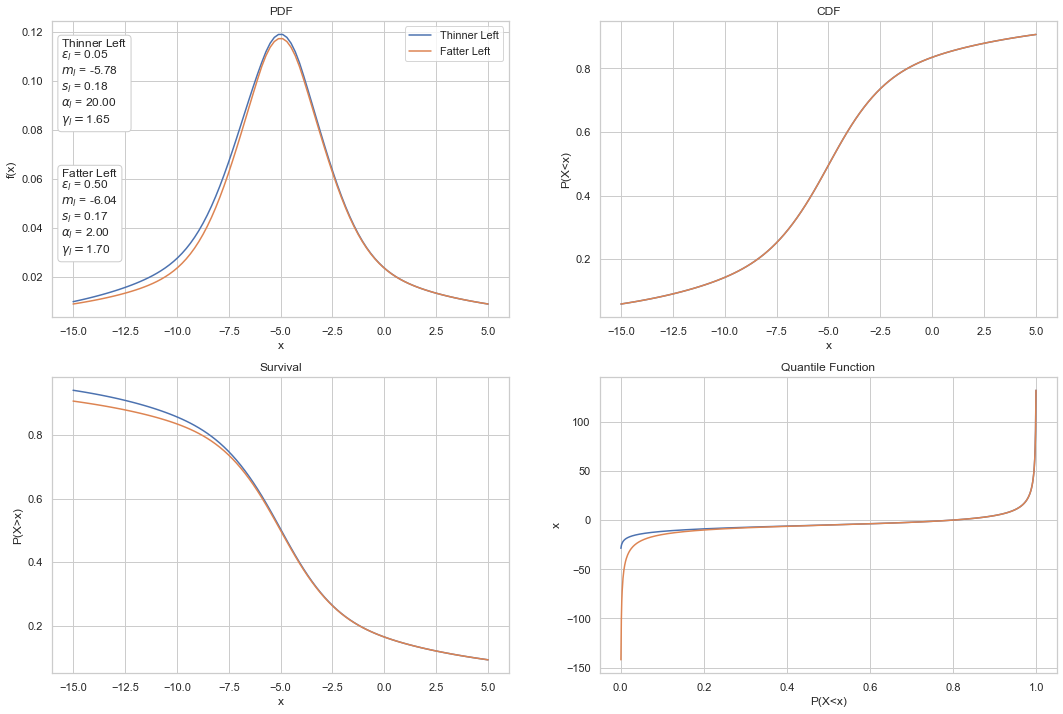

In [39]:
mean, std = -5, 2
x = np.linspace(-10+mean, 10+mean, 100)
shape_l1, shape_r = 1/20, 1/2
dist1 = PHAT(x, mean, std, shape_l1, shape_r)
shape_l2, shape_r = 1/2, 1/2
dist2 = PHAT(x, mean, std, shape_l2, shape_r,)

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(18,12))

ax1.plot(x, dist1.pdf(), label='Thinner Left')
ax1.plot(x, dist2.pdf(), label='Fatter Left')

paramtxt = r'Thinner Left$_{}$'
paramtxt += '\n'
paramtxt += r'$\epsilon_{l}$ = ' + f'{dist1.left.shape:.2f}'
paramtxt += '\n'
paramtxt += r'$m_l$ = ' + f'{dist1.left.loc:.2f}'
paramtxt += '\n'
paramtxt += r'$s_l$ = ' + f'{1 / dist1.left.scale:.2f}'
paramtxt += '\n'
paramtxt += r'$\alpha_l$ = ' + f'{1 / dist1.left.shape:.2f}'
paramtxt += '\n'
paramtxt += r'$\gamma_l = $' + f'{dist1.left.gamma:.2f}'

ax1.text(
    .02,.95, paramtxt, va='top',
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)
paramtxt = r'Fatter Left$_{}$'
paramtxt += '\n'
paramtxt += r'$\epsilon_{l}$ = ' + f'{dist2.left.shape:.2f}'
paramtxt += '\n'
paramtxt += r'$m_l$ = ' + f'{dist2.left.loc:.2f}'
paramtxt += '\n'
paramtxt += r'$s_l$ = ' + f'{1 / dist2.left.scale:.2f}'
paramtxt += '\n'
paramtxt += r'$\alpha_l$ = ' + f'{1 / dist2.left.shape:.2f}'
paramtxt += '\n'
paramtxt += r'$\gamma_l = $' + f'{dist2.left.gamma:.2f}'

ax1.text(
    .02,.2, paramtxt, va='bottom',
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)

ax2.plot(x, dist1.cdf())
ax2.plot(x, dist1.cdf())

ax3.plot(x, dist1.sf())
ax3.plot(x, dist2.sf())

q = np.linspace(0,.999,1000)
ax4.plot(q, dist1.ppf(q))
ax4.plot(q, dist2.ppf(q))

ax1.legend()

ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax2.set_xlabel('x')
ax2.set_ylabel('P(X<x)')
ax3.set_xlabel('x')
ax3.set_ylabel('P(X>x)')
ax4.set_xlabel('P(X<x)')
ax4.set_ylabel('x')

ax1.set_title('PDF')
ax2.set_title('CDF')
ax3.set_title('Survival')
ax4.set_title('Quantile Function')

plt.show()

Below we can see random variables drawn from the two distributions will generally draw larger minimum samples in the distribution with the thicker left tail.

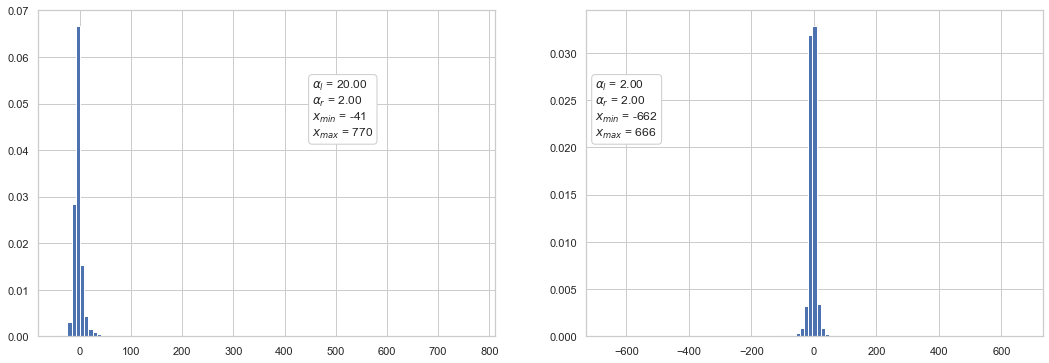

In [40]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))
n = 10000
x = np.linspace(-40, 40, 1000)
rvs1 = dist1.rvs(n)
rvs2 = dist2.rvs(n)

ax1.hist(rvs1, bins=np.linspace(rvs1.min(), rvs1.max(), 100), density=True)
ax2.hist(rvs2, bins=np.linspace(rvs2.min(), rvs2.max(), 100), density=True)

paramtxt = r'$\alpha_l$ = ' + f'{1 / dist1.left.shape:.2f}'
paramtxt += '\n'
paramtxt += r'$\alpha_r$ = ' + f'{1 / dist1.right.shape:.2f}'
paramtxt += '\n'
paramtxt += r'$x_{min}$ = ' + f'{rvs1.min():,.0f}'
paramtxt += '\n'
paramtxt += r'$x_{max}$ = ' + f'{rvs1.max():,.0f}'
ax1.text(
    .6, .6, paramtxt, va='bottom',
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)

paramtxt = r'$\alpha_l$ = ' + f'{1 / dist2.left.shape:.2f}'
paramtxt += '\n'
paramtxt += r'$\alpha_r$ = ' + f'{1 / dist2.right.shape:.2f}'
paramtxt += '\n'
paramtxt += r'$x_{min}$ = ' + f'{rvs2.min():,.0f}'
paramtxt += '\n'
paramtxt += r'$x_{max}$ = ' + f'{rvs2.max():,.0f}'
ax2.text(
    .02,.6, paramtxt, va='bottom',
    transform=ax2.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)

plt.show()

### Threshold Analysis for PHAT ###

Earlier we used threshold analysis to estimate tail characteristics of the positive tail log daily returns in the S&P 500, then we assumed similar characteristics in the left tail. This time around, we will repeat the analysis with the data reflected, to see if it results in different parameters.

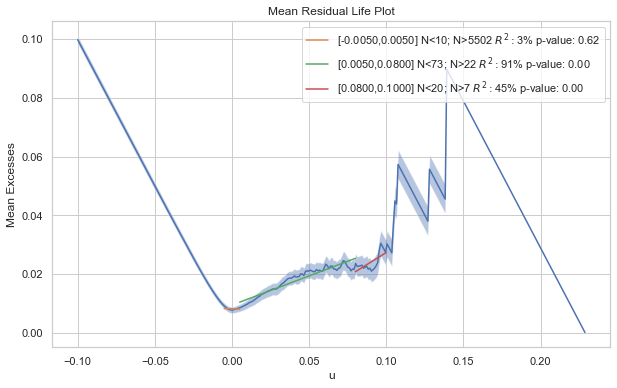

In [41]:
thold = Threshold(-sp_lret)
splits = [-.005, .005, .08, .1]
thold.MRL(splits=splits)
plt.show()

Above we see good linear approximations through 0.5% daily returns all the way out to 8%.

../../../../analysis/options/pricing/thold.py:123: RuntimeWarning: invalid value encountered in double_scalars
  CI_mod_scale.append((Var_mod_scale**0.5)*z)


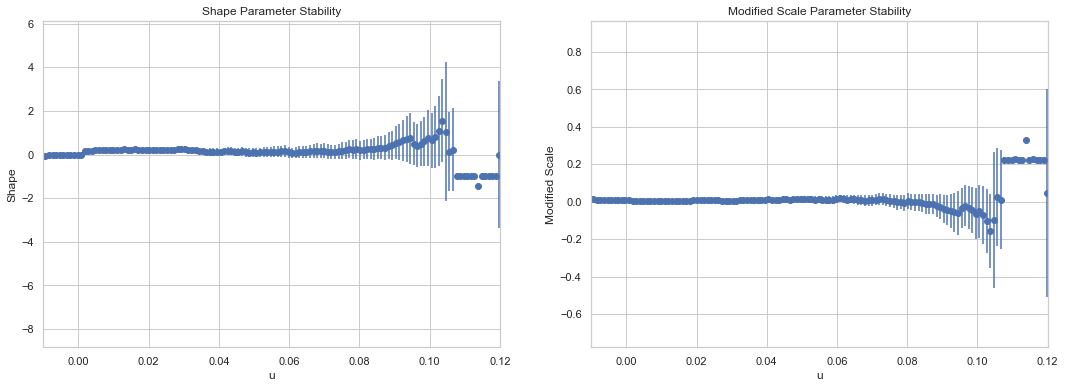

In [42]:
fig, axs = plt.subplots(1,2,figsize=(18,6))
thold.param_stable(spacer=5, fig=fig, axs=axs)
axs[0].set_xlim((-0.01, .12))
axs[1].set_xlim((-0.01, .12))
plt.show()

In the parameter stability we see both the scale and shape parameters start to breakdown in the 6% to 7% range.

../../../../analysis/options/pricing/thold.py:178: RuntimeWarning: invalid value encountered in double_scalars
  CI_qq_high.append(thold + ((scale/shape)*(((1-((F2)/(1)))**-shape) - 1)))


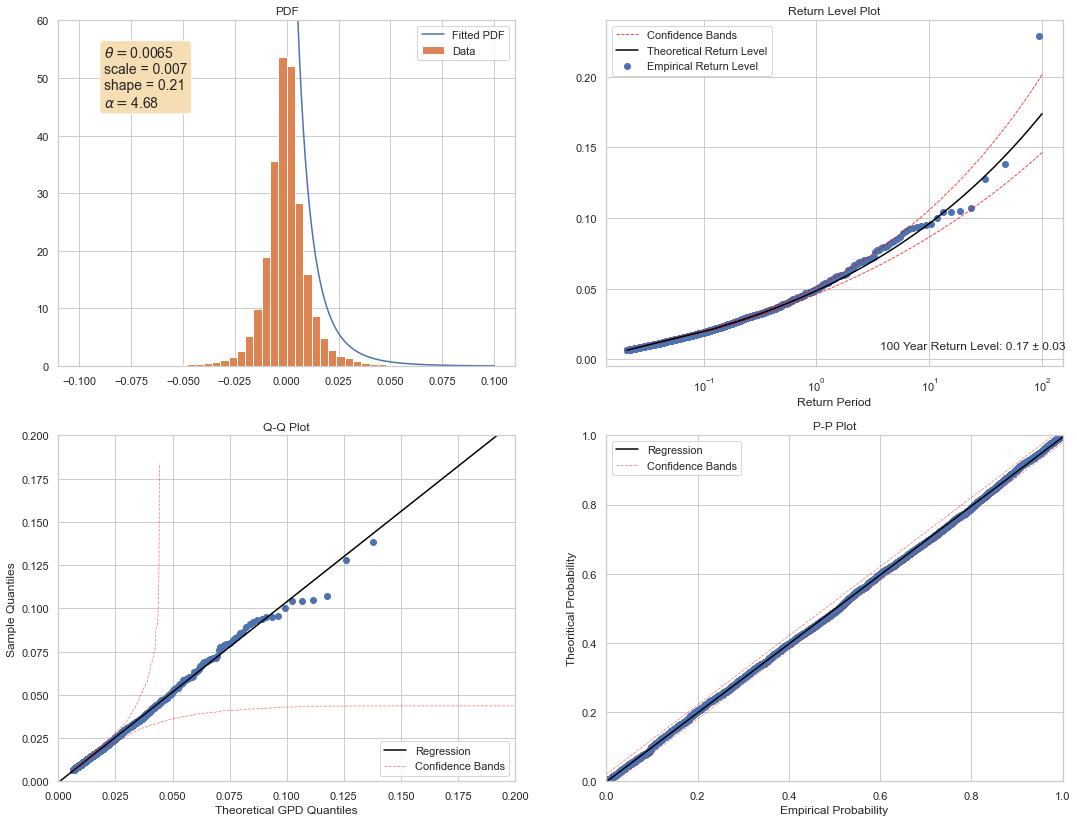

In [43]:
thresh = 0.0065
fit, _, over_thresh = thold.fit(thold=thresh)
scale, shape = fit[0][0], fit[0][1]

x = np.linspace(0, .1, 101)

fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,14))

ax1.plot(x, scist.genpareto.pdf(x, shape, scale=scale), label='Fitted PDF')
counts, bins, _ = ax1.hist(thold.data, bins=np.linspace(-.1,.1,51), density=True, label='Data')

txt = r'$\theta = $' + f'{thresh}'
txt += '\n'
txt += f'scale = {scale:.3f}'
txt += '\n'
txt += f'shape = {shape:.2f}'
txt += '\n'
txt += r'$\alpha = $' + f'{1/shape:.2f}'
props = dict(boxstyle='round', facecolor='wheat')
ax1.text(.1, .75, txt, transform=ax1.transAxes, fontsize=14, bbox=props)

ax1.set_ylim((0, 60))
ax1.set_title('PDF')
ax1.legend()

thold.return_value(thold=thresh, fig=fig, ax=ax2)

thold.qqplot(thold=thresh, fig=fig, ax=ax3)
thold.ppplot(thold=thresh, fig=fig, ax=ax4)

ax3.set_xlim((0,.2))
ax3.set_ylim((0,.2))

ax4.set_xlim((0,1))
ax4.set_ylim((0,1))

plt.show()

../../../../analysis/options/pricing/thold.py:178: RuntimeWarning: invalid value encountered in double_scalars
  CI_qq_high.append(thold + ((scale/shape)*(((1-((F2)/(1)))**-shape) - 1)))


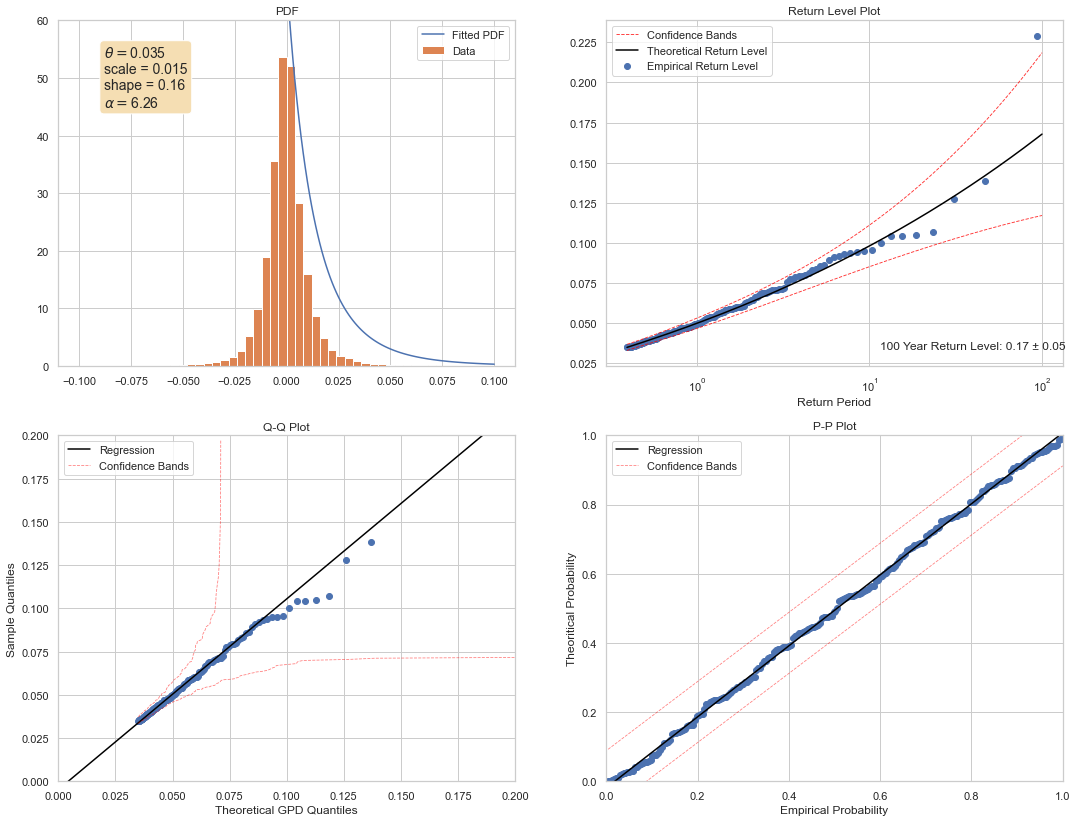

In [44]:
thresh = 0.035
fit, _, over_thresh = thold.fit(thold=thresh)
scale, shape = fit[0][0], fit[0][1]

x = np.linspace(0, .1, 101)

fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,14))

ax1.plot(x, scist.genpareto.pdf(x, shape, scale=scale), label='Fitted PDF')
counts, bins, _ = ax1.hist(thold.data, bins=np.linspace(-.1,.1,51), density=True, label='Data')

txt = r'$\theta = $' + f'{thresh}'
txt += '\n'
txt += f'scale = {scale:.3f}'
txt += '\n'
txt += f'shape = {shape:.2f}'
txt += '\n'
txt += r'$\alpha = $' + f'{1/shape:.2f}'
props = dict(boxstyle='round', facecolor='wheat')
ax1.text(.1, .75, txt, transform=ax1.transAxes, fontsize=14, bbox=props)

ax1.set_ylim((0, 60))
ax1.set_title('PDF')
ax1.legend()

thold.return_value(thold=thresh, fig=fig, ax=ax2)

thold.qqplot(thold=thresh, fig=fig, ax=ax3)
thold.ppplot(thold=thresh, fig=fig, ax=ax4)

ax3.set_xlim((0,.2))
ax3.set_ylim((0,.2))

ax4.set_xlim((0,1))
ax4.set_ylim((0,1))

plt.show()

Interestingly, the trade-off between tail thickness is less dramatic to the downside.

### Finding the Middle Ground ###

Of course, with the PHAT model, we not only have the two Pareto distributions in the tails to estimate. We must also estimate the Gaussian in the body!

To do so, we will simply filter out the observations outside of the tail thresholds. For this process, we will choose symmetrical thresholds, as they would otherwise skew the resulting normal in either direction. We will select tail thresholds as follows:

+ $\theta_l, \theta_r = -0.035, 0.035$
+ $\theta_l, \theta_r = -0.015, 0.015$
+ $\theta_l, \theta_r = -0.01, 0.01$

In [45]:
tholds = np.array([.0035, .005, .00625, .0075, .01, .5])
tholds = np.vstack((-tholds, tholds)).T

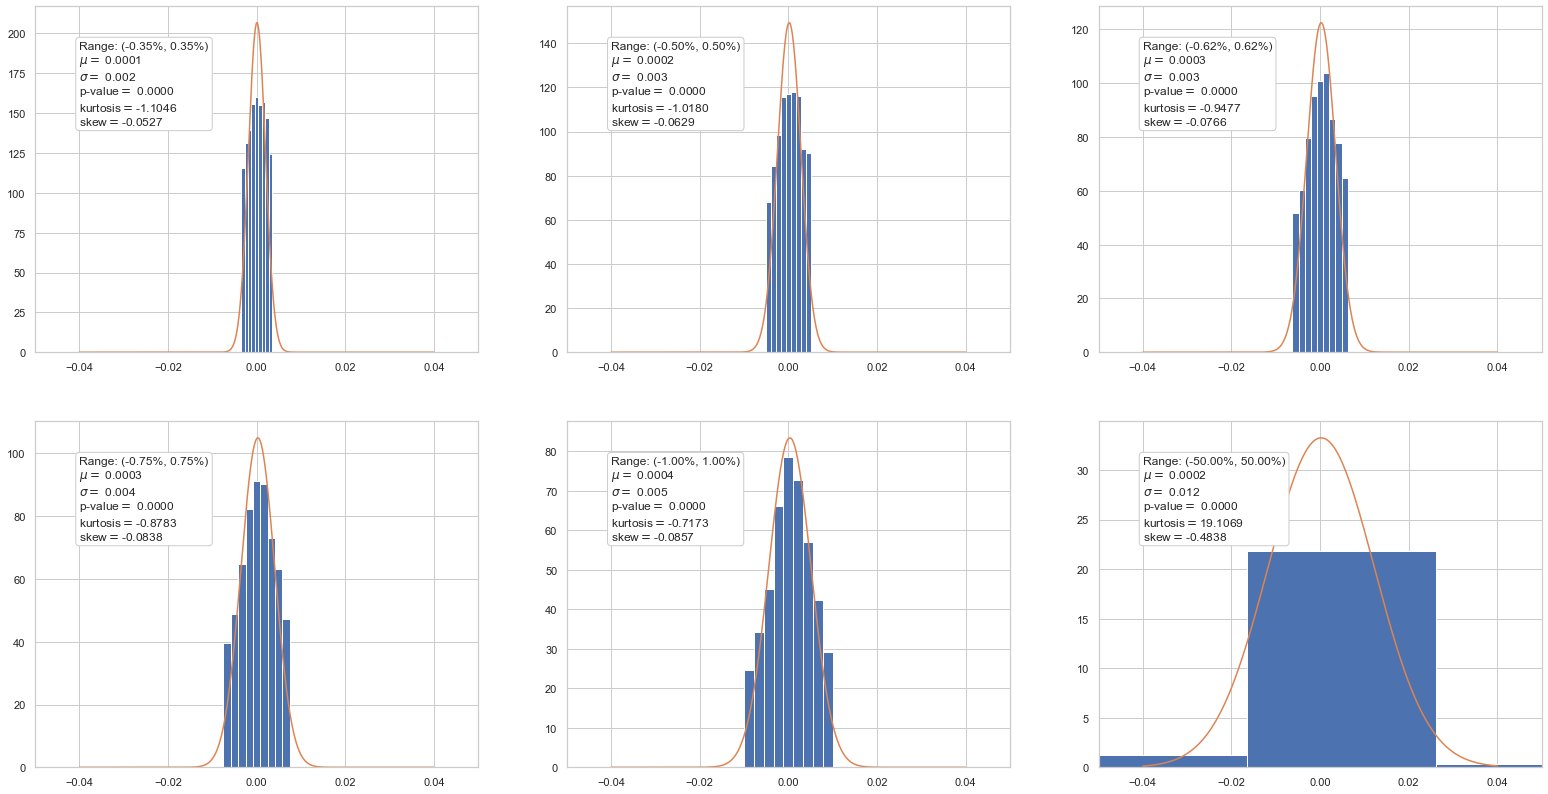

In [46]:
x = np.linspace(-.04, .04, 1000)

fig, axs = plt.subplots(2,3,figsize=(27,14))
axs = axs.flatten()
fits = []
for i in range(axs.size):
    ax = axs[i]
    loc_l, loc_r = tholds[i]
    body_rets = sp_lret[(sp_lret>loc_l) & (sp_lret<loc_r)]
    mean, std = scist.norm.fit(body_rets)
    fits.append((mean, std))
    _, p_value = scist.normaltest(body_rets)
    kurt = scist.kurtosis(body_rets)
    skew = scist.skew(body_rets)
    
    bins = np.linspace(body_rets.min(), body_rets.max(), 10)
    ax.hist(body_rets, bins=bins, density=True)
    ax.plot(x, scist.norm.pdf(x, mean, std))

    ax.set_xlim((-.05, .05))
    txt = f'Range: ({loc_l:.2%}, {loc_r:.2%})'
    txt += '\n'    
    txt += r'$\mu = $ ' + f'{mean:.4f}'
    txt += '\n'
    txt += r'$\sigma = $ ' + f'{std:.3f}'
    txt += '\n'
    txt += r'p-value$ = $ ' + f'{p_value:.4f}'
    txt += '\n'
    txt += r'kurtosis$ = $' + f'{kurt:.4f}'
    txt += '\n'
    txt += r'skew$ = $' + f'{skew:.4f}'

    ax.text(
        .1, .9, txt, transform=ax.transAxes, ha='left', va='top',
        bbox=dict(boxstyle='round', ec='.8', fc='w')
    )


plt.show()

We also include the full range for comparison purposes.

First note the ***sinister*** nature of fitting to the normal distribution. Every fit has a p-value with significance > .0001%, yet when we look at the entire distribution, the kurtosis is 10-100x larger. When we fit to a normal, that kurtosis is lost and investors are exposed significant tail risk.

Note that the range of means is very narrow, and the standard deviation increases as we broaden the range.

The kurtosis and skew appear to be minimized around .02% daily continuous returns.

### Simulation of Share Price ###

In [47]:
mean, std = fits[2]
shape_l, shape_r = .18, .18
x = np.linspace(-.1, .1, 1000)
dist = PHAT(x, mean, std, shape_l, shape_r)

In [48]:
dist.left.loc, dist.right.loc, dist.left.scale, dist.right.scale

(-0.0011477937996059696,
 0.0016496286821918958,
 0.008955075526512412,
 0.008955075526512412)

NameError: name 'sp_lret' is not defined

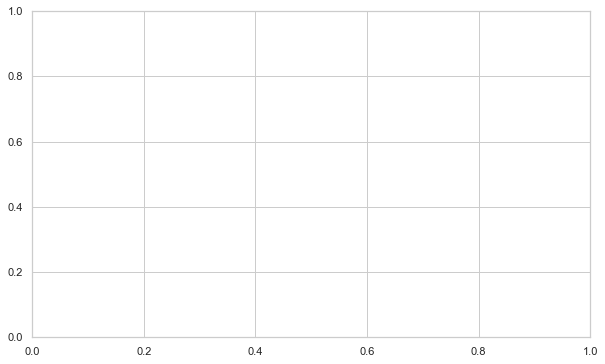

In [5]:
fig, ax = plt.subplots(1,1,figsize=(10,6))

bins = np.linspace(sp_lret.min(), sp_lret.max(), 100)
ax.hist(sp_lret, bins=bins, density=True)
ax.plot(x, dist.pdf())

ax.set_xlim((-.05, .05))

paramtxt = 'Body'
paramtxt += '\n'
paramtxt += r'$\mu, \sigma$ = ' + f'{dist.mean:.4f}, {dist.std:.4f}'
ax.text(
    .5, .01, paramtxt, ha='center', va='bottom',
    transform=ax.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)

paramtxt = r'Left Tail$_{}$'
paramtxt += '\n'
paramtxt += r'$\epsilon_{l}$ = ' + f'{dist.shape_l:.2f}'
paramtxt += '\n'
paramtxt += r'$m_l$ = ' + f'{dist.left.loc:.4f}'
paramtxt += '\n'
paramtxt += r'$s_l$ = ' + f'{1 / dist.left.scale:.2f}'
paramtxt += '\n'
paramtxt += r'$\alpha_l$ = ' + f'{1 / dist.left.shape:.2f}'
paramtxt += '\n'
paramtxt += r'$\gamma_l = $' + f'{dist.left.gamma:.2f}'

ax.text(
    .02, .98, paramtxt, va='top',
    transform=ax.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)
paramtxt = r'Right Tail$_{}$'
paramtxt += '\n'
paramtxt += r'$\epsilon_r$ = ' + f'{dist.right.shape:.2f}'
paramtxt += '\n'
paramtxt += r'$m_r$ = ' + f'{dist.right.loc:.4f}'
paramtxt += '\n'
paramtxt += r'$s_r$ = ' + f'{1 / dist.right.scale:.2f}'
paramtxt += '\n'
paramtxt += r'$\alpha_r$ = ' + f'{1 / dist.right.shape:.2f}'
paramtxt += '\n'
paramtxt += r'$\gamma_r = $' + f'{dist.right.gamma:.2f}'

ax.text(
    .98, .98, paramtxt, ha='right', va='top',
    transform=ax.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)

plt.show()

From the above we note a few things:

+ first, notice the improvement in fit versus 
+ the left and right junction points create a very narrow range for the Guassian body of the distribution. The Gaussian simply arrests the explosive assymptotic behavior of the Pareto as it approaches the mean. The flattening of the head results in more (but not many more!) observations are pushed well out into the tails. In this sense, the Gaussian is more of a capstone than a body.
+ the capstone effect of driving observations into the tails is accomplished by a dramatically higher scaling factor for the Pareto tails than was estimated via the threshold analysis. the sound fit here is empirical support of the primacy of the tail index over other factors.

Another decent test of fit is to compare the number of observations in data at certain thresholds versus a random sample from the fit. Here we compare for 100,000 samples:

In [51]:
n = 100000
logrets = dist.rvs(size=n)

(np.abs(logrets) < .01).sum() / logrets.size, (sp_lret.abs() < .01).sum() / sp_lret.size

(0.74306, 0.7584327086882453)

In [53]:
(np.abs(logrets) < .001).sum() / logrets.size, (sp_lret.abs() < .001).sum() / sp_lret.size

(0.10731, 0.1198892674616695)

In [54]:
f'{(np.abs(logrets) > .1).sum() / logrets.size:.3E}', f'{(sp_lret.abs() > .1).sum() / sp_lret.size:.3E}'

('2.600E-04', '5.963E-04')

Here we see strong consistency with observations. In fact, our tail events above 10% daily return happen a fair amount MORE frequently, which I believe Taleb would agree to err on in terms of caution.

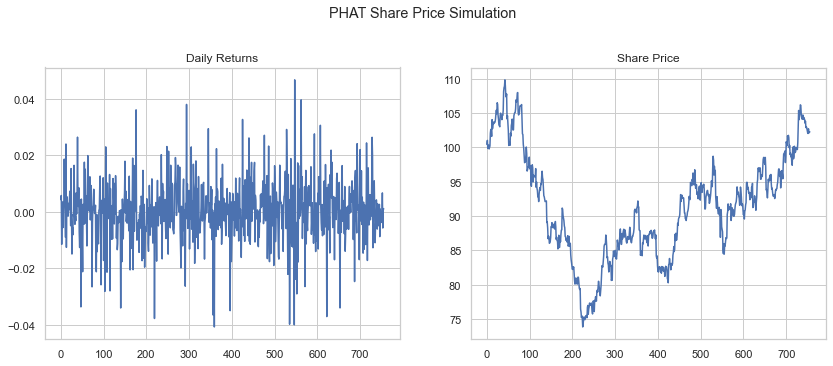

In [55]:
days = 252*3
x = np.arange(days)

logrets = dist.rvs(size=x.shape)
rets = np.exp(logrets)
S0 = 100
S = S0*rets.cumprod()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))

ax1.plot(x, (rets - 1).reshape(-1,1))
ax2.plot(x, S)

ax1.set_title('Daily Returns')
ax2.set_title('Share Price')

plt.suptitle('Phat Share Price Simulation', y=1.05)
plt.show()

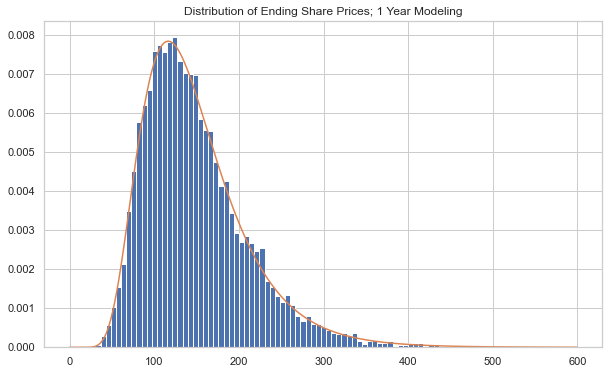

In [150]:
n = 10000
logrets = dist.rvs(size=(n, days*5))
rets = np.exp(logrets)
S0 = 100
S = (S0)*rets.cumprod(axis=1)
lnorm = scist.lognorm(*scist.lognorm.fit(S[:, -1]))

fig, ax = plt.subplots(1,1,figsize=(10,6))

counts, bins, _ = ax.hist(S[:, -1], bins=np.linspace(0, S[:, -1].max(), 100), density=True)
x = np.linspace(0,S[:, -1].max(), 1000)
ax.plot(x, lnorm.pdf(x))

ax.set_title('Distribution of Ending Share Prices; 1 Year Modeling')
plt.show()

In [153]:
S[:, -1].min(), lnorm.pdf(S[:, -1].min())

(32.26145321589101, 4.495071900003962e-05)

## Pitfalls ##

One important issue overlooked in the above analysis is the autoregressive nature of share prices. One underlying key assumption in the above is that each daily return is an independent observation. Instead, daily returns do tend to be correlated with recent historical observations. GARCH models are often used as a result. [Mandlebrot (1996)](https://users.math.yale.edu/~bbm3/web_pdfs/Cowles1164.pdf) proposed a fractal model with his characteristic fat tails and "long-term dependence" (also known as long-term memory), which allows for the influence of more distant historical observations.

There are different approaches that can be used to account for auto-correlation.

+ A "declustering" technique was proposed in Coles that groups nearby fat-tail observations into a single observation. This approach has been criticized as it removes information.
+ Threshold analysis can be performed *after* an adjustment for autocorrelation has been made.

The major drawback of incorporating some kind of autocorrelation, of course, is that a simulation of an autocorrelated variable must be done iteratively, leading to a dramatic deterioration in the speed a simulation is produced.

Techniques that support fast iteration, such as the use of Numba in Python, could offset this.

Finally, Taleb would likely argue that, certainly in terms of resilience and risk mitigation, the autocorrelative effects would most abundantly be experienced in the body, and the tails will have far greater influence on the payoff and so autocorrelation can be comfortably ignored heuristically.